# AirBnB Data Analysis: Data Cleaning and Exploratory Data Analysis

In the current repository, I will analyze the [AirBnB dataset from the Basque Country / Euskadi](http://insideairbnb.com/get-the-data/). The [Basque Country](https://en.wikipedia.org/wiki/Basque_Country_(autonomous_community)) is the region from Spain I am from; after many years living in Germany, I moved back here in 2020. As a popular touristic target on the seaside, the analysis might be valuable for many visitors :-)

The previous notebook `00_AirBnB_DataAnalysis_Initial_Tests.ipynb` has defined the main business questions, related to:

1. Most important features for price prediction (= target)
2. Difference in features between the two most important cities: Donostia-San Sebastian & Bilbao
3. Difference in features between cities with beach access and without
4. EXTRA: Predict review score from review texts

Now, the usual data science process continues:

1. Data cleaning and Preparation
2. Exploratory Data Analysis
3. Feature Engineering
4. Feature Selection
5. Modelling
6. Scoring
7. Answering and presenting the Business Questions

This notebook focuses on the the first two steps: **Data Cleaning** and **Exploratory Data Analysis (EDA)**. Any transformations done in the previous notebook are re-done here; thus, the previous notebook is a mere inital contact for the formulation of the business questions. The file after the **data cleaning** saved here is the input for the next notebook: `02_AirBnB_DataAnalysis_FeatureEngineering_and_Selection.ipynb`. Therefore, although teh dataset is transformed during the EDA part for visualization, those transformations are repeated again in the next notebook. 

### Overview of Contents in the Current Notebook

1. Load and Set Up Dataset
2. Data cleaning and Preparation
    - 2.1 Missing Values: Remove & Impute
    - 2.2 Missing Values: Infer / Process
        - Beds & Bedrooms
        - Host location
3. Exploratory Data Analysis
    - 3.1 Detect Variable Types
    - 3.2 Numerical/Continuous Variables
        - Distributions
        - Scatterplots & Selection of Transformations
        - Correlations
        - Distribution of Price & Reviews Depending on Access to Beach
        - Distribution of Price & Reviews Depending on Major Cities
        - Numerical Variables that Are Discrete (Cardinal Data)
        - Price Display in Coordinates Scatterplot (Longitude & Latitude)
    - 3.3 Categorical Variables
        - Get Number of Categories
        - Boxplots of Categoricals with Few Categories
        - Encoding/Mapping of Categories
        - Variables with Many Categories: Property Type
    - 3.4 Geographical Information: Choropleths

In [336]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats

# Display all the columns of the dataframe in the notebook
pd.pandas.set_option('display.max_columns', None)

## 1. Load and Set Up Dataset

I repeat the simplification and reduction steps from previous notebook.

In [337]:
#filename = './data/euskadi_2022_03_31/listings_detailed_reduced.csv'
#listings = pd.read_csv(filename)
listings = pd.read_csv('./data/euskadi_2022_03_31/listings_detailed.csv',encoding='utf-8')

In [338]:
# Some location names are not correctly encoded?
# Fix location/neighborhood names; even thhough UTF-8 is used, names where encoded differently?
listings['neighbourhood_group_cleansed'] = listings['neighbourhood_group_cleansed'].replace({'GuipÃºzcoa':'Gipuzkoa',
                                                                                             'Ãlava':'Araba',
                                                                                             'Vizcaya': 'Bizkaia'})
listings['neighbourhood_cleansed'] = listings['neighbourhood_cleansed'].replace({'Donostia-San SebastiÃ¡n':'Donostia-San Sebastian',
                                                                                 'UrduÃ±a-OrduÃ±a':'Urduna-Orduna',
                                                                                 'ValdegovÃ­a':'Valdegovia',
                                                                                 'Mungai':'Mungia'})

Percent of listings in most listed 60 / 196 neighborhoods: 0.8928844682478958


<AxesSubplot:>

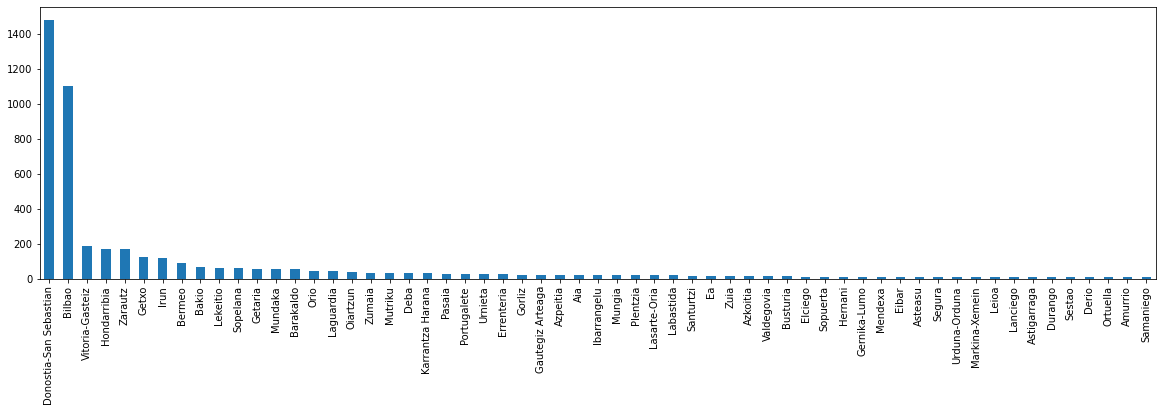

In [339]:
# There are almost 200 city/towns 
all_neighbourhoods = listings["neighbourhood_cleansed"].value_counts()
num_listings_per_neighborhood = all_neighbourhoods/all_neighbourhoods.sum()
num_neighborhoods = 60
print(f"Percent of listings in most listed {num_neighborhoods} / {len(all_neighbourhoods)} neighborhoods: {num_listings_per_neighborhood[0:num_neighborhoods-1].sum()}")

# Plot selected neighborhoods with listing counts
plt.figure(figsize=(20,5))
all_neighbourhoods[0:num_neighborhoods-1].plot(kind="bar")

In [340]:
# Get a list of all selected locations
all_selected_locations = list(all_neighbourhoods[0:num_neighborhoods-1].index)

In [341]:
# Locations with a beach in less than 2km (checked manually in Google Maps)
# New feature that could explain price/reviews
beach_locations = ['Donostia-San Sebastian', 'Hondarribia',
       'Zarautz', 'Getxo', 'Irun', 'Bermeo', 'Bakio', 'Lekeitio', 'Sopelana',
       'Getaria', 'Mundaka', 'Orio', 'Zumaia', 'Mutriku', 'Deba', 'Portugalete',
       'Gorliz', 'Gautegiz Arteaga', 'Ibarrangelu', 'Plentzia', 'Santurtzi', 'Ea',
       'Busturia', 'Gernika-Lumo', 'Mendexa', 'Leioa', 'Astigarraga', 'Sestao',
       'Ortuella']

In [342]:
# Half of the selected locations are coastal places or are close to a beach
len(beach_locations)

29

In [343]:
# Price is encoded as a string; convert it to float
listings['price'] = listings['price'].replace('[\$,]', '', regex=True).astype(float)

In [344]:
# Manual selection of relevant columns
# Initial drop; feature engineering selection needs to be done yet
# Can be removed: 'scrape_id', 'last_scraped', 'picture_url', 'host_url', 'host_thumbnail_url', 'host_picture_url', 'bathrooms', 'calendar_last_scraped'
selected_features = ['id', 'name', 'listing_url', 'description',
       'neighborhood_overview', 'host_id', 'host_name', 'host_since', 'host_location', 'host_about',
       'host_response_time', 'host_response_rate', 'host_acceptance_rate',
       'host_is_superhost', 
       'host_neighbourhood', 'host_listings_count',
       'host_total_listings_count', 'host_verifications',
       'host_has_profile_pic', 'host_identity_verified', 'neighbourhood',
       'neighbourhood_cleansed', 'neighbourhood_group_cleansed', 'latitude',
       'longitude', 'property_type', 'room_type', 'accommodates', 
       'bathrooms_text', 'bedrooms', 'beds', 'amenities', 'price',
       'minimum_nights', 'maximum_nights', 'minimum_minimum_nights',
       'maximum_minimum_nights', 'minimum_maximum_nights',
       'maximum_maximum_nights', 'minimum_nights_avg_ntm',
       'maximum_nights_avg_ntm', 'calendar_updated', 'has_availability',
       'availability_30', 'availability_60', 'availability_90',
       'availability_365', 'number_of_reviews',
       'number_of_reviews_ltm', 'number_of_reviews_l30d', 'first_review',
       'last_review', 'review_scores_rating', 'review_scores_accuracy',
       'review_scores_cleanliness', 'review_scores_checkin',
       'review_scores_communication', 'review_scores_location',
       'review_scores_value', 'license', 'instant_bookable',
       'calculated_host_listings_count',
       'calculated_host_listings_count_entire_homes',
       'calculated_host_listings_count_private_rooms',
       'calculated_host_listings_count_shared_rooms', 'reviews_per_month']

In [345]:
# Initial size
listings.shape

(5228, 74)

In [346]:
# Remove price outliers
listings = listings[listings.price <= 1000]

In [347]:
# Take only relevant features
listings = listings[selected_features]

In [348]:
# Take only items from all_selected_locations
listings['selected_location'] = listings['neighbourhood_cleansed'].apply(lambda x: 1 if x in all_selected_locations else 0)
listings = listings[listings.selected_location == 1]
listings.drop(['selected_location'], axis=1, inplace=True)

In [349]:
# New feature: has_beach - if beach access in less than 2km
listings['has_beach'] = listings['neighbourhood_cleansed'].apply(lambda x: 1 if x in beach_locations else 0)

In [350]:
# Percent of listings associated with a location with access to a beach
listings['has_beach'].sum()/listings.shape[0]

0.6072813442481689

In [351]:
# New feature: review_scores_average
review_cols = ['review_scores_rating', 'review_scores_accuracy',
               'review_scores_cleanliness', 'review_scores_checkin',
               'review_scores_communication', 'review_scores_location',
               'review_scores_value']
listings['review_scores_average'] = listings[review_cols].mean(axis=1)

In [352]:
# Final shape
listings.shape

(4642, 68)

In [353]:
# Store new file
filename = './data/euskadi_2022_03_31/listings_detailed_reduced.csv'
listings.to_csv(filename, index=False, header=True)

## 2. Data cleaning and Preparation

In [389]:
df = listings.copy()

In [390]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4642 entries, 0 to 5227
Data columns (total 68 columns):
 #   Column                                        Non-Null Count  Dtype  
---  ------                                        --------------  -----  
 0   id                                            4642 non-null   int64  
 1   name                                          4642 non-null   object 
 2   listing_url                                   4642 non-null   object 
 3   description                                   4554 non-null   object 
 4   neighborhood_overview                         2555 non-null   object 
 5   host_id                                       4642 non-null   int64  
 6   host_name                                     4642 non-null   object 
 7   host_since                                    4642 non-null   object 
 8   host_location                                 4638 non-null   object 
 9   host_about                                    2385 non-null   o

### 2.1 Missing Values: Remove & Impute

Text(0.5, 1.0, 'Total Missing Values')

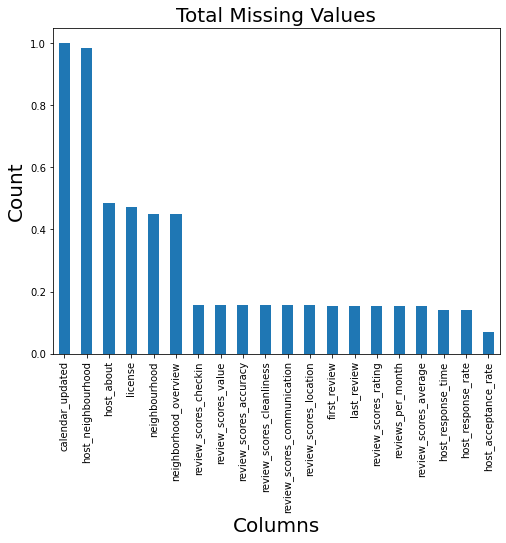

In [391]:
# Detect missing values, sort them ascending, plot
# I would drop all features/columns with more than 15% of missing values
# and impute with the median/mean the rest; maybe impute with median the ones with =<%5
# predict the ones with 5-15%; unless these are the ones to be predicted
total = df.isnull().sum().sort_values(ascending=False)
total_select = total/df.shape[0] # Normalize to get percentages
total_select = total_select.head(20) # Select the 20 most relevant feeatures
total_select.plot(kind="bar", figsize = (8,6), fontsize = 10)
plt.xlabel("Columns", fontsize = 20)
plt.ylabel("Count", fontsize = 20)
plt.title("Total Missing Values", fontsize = 20)

In [392]:
# Manual selection of columns to drop
# Reason: less than 80% non-null values
# Exception: license - assumed license only when non-null
try:
    cols_drop = ['calendar_updated','host_neighbourhood','host_about','neighbourhood','neighborhood_overview']
    df.drop(cols_drop, axis=1, inplace=True)
except KeyError as err:
    print("Columns already removed!")

In [393]:
# Show missing values, sort them ascending
df.isnull().sum().sort_values(ascending=False).head(25)

license                                        2191
review_scores_communication                     727
review_scores_accuracy                          727
review_scores_cleanliness                       727
review_scores_checkin                           727
review_scores_location                          727
review_scores_value                             727
first_review                                    711
last_review                                     711
review_scores_rating                            711
review_scores_average                           711
reviews_per_month                               711
host_response_rate                              653
host_response_time                              653
host_acceptance_rate                            324
bedrooms                                        108
beds                                             91
description                                      88
bathrooms_text                                   24
host_locatio

In [394]:
# Further columns/features to remove: different topic reviews
# Reasons: to simplify, since the average is going to be used
review_cols = ['review_scores_rating', 'review_scores_accuracy',
               'review_scores_cleanliness', 'review_scores_checkin',
               'review_scores_communication', 'review_scores_location',
               'review_scores_value']
df.drop(review_cols, axis=1, inplace=True)

In [395]:
# Data-points to remove: All items with null values in:
#   review_scores_* , first_review, last_review, reviews_per_month
# Reasons: these fields either are used to define the target or are essential for it
#rows_remove = ['review_scores_communication','review_scores_accuracy','review_scores_cleanliness',
#               'review_scores_checkin','review_scores_location','review_scores_value',
#               'review_scores_rating','review_scores_average',
#               'first_review', 'last_review', 'reviews_per_month']
rows_remove = ['review_scores_average',
               'first_review', 'last_review', 'reviews_per_month']
df.dropna(subset=rows_remove, inplace=True)

# Show missing values again, sort them ascending
df.isnull().sum().sort_values(ascending=False).head(10)

license                 1699
host_response_rate       456
host_response_time       456
host_acceptance_rate     176
bedrooms                  80
beds                      58
description               56
bathrooms_text             8
host_location              3
availability_90            0
dtype: int64

In [396]:
# Data-point values to impute: mean / median / mode
#   host_response_rate, host_response_time, host_acceptance_rate, bathrooms_text
#  Data-point values to process or infer from other fields, else impute with mode / mean / median
#   description, bedrooms, beds
#   license, host_location
# Reasons:
rows_impute = ['host_response_rate', 'host_response_time', 'host_acceptance_rate', 'bathrooms_text']
for col in rows_impute:
    if df[col].dtype == 'O':
        col_summary = df[col].mode()[0]
    elif df[col].dtype == 'float64' or df[col].dtype == 'int64':
        col_summary = df[col].median()
    df.fillna(value={col:col_summary}, inplace=True)
    #df[col].replace(np.nan, col_summary)

# Show missing values again, sort them ascending
df.isnull().sum().sort_values(ascending=False).head(6)

license          1699
bedrooms           80
beds               58
description        56
host_location       3
id                  0
dtype: int64

In [397]:
df.shape

(3931, 56)

### 2.2 Missing Values: Infer / Process

Now, we have 5 features left to be processed:

- license: we assume if NaN there is no license
- description: replace missing with name
- bedrooms & beds: infer from mode of each category in the counterpart feature; then inpute mode for missing
- host_location: will be replaced by host_location_in_property_neighborhood; then we impute mode

In [398]:
# License: if the field has something, assume we have a license, else not
try:
    df['license_reported'] = df['license'].isnull()
    df['license_reported'] = df['license_reported'].apply(lambda col: 1 if not col else 0)
    # Remove old feature
    df.drop(['license'], axis=1, inplace=True)
except KeyError as err:
    print("Column already removed!")

In [399]:
# Description: fill NaN values with name
df['description'].fillna(df['name'],inplace=True)

#### Beds & Bedrooms

The number of beds and bedrooms are related and one could guess the value of the other observing the population values. Thus, the stratagy to fill the missing values is the following:

- Stratify / group the dataset by beds and bedrooms
- Get the median for each stratum
- Locate the row with missing beds and bedrooms
- If a row with a missing bed has a valid bedrooms value, get the median of beds associated for that number of bedrooms
- Do the analogous with the bedrooms

In [400]:
# For each category of number of bedrooms, median of beds
beds_per_bedroom = df.groupby('bedrooms')['beds'].median()
beds_per_bedroom

bedrooms
1.0      1.0
2.0      3.0
3.0      4.0
4.0      6.0
5.0      8.0
6.0      9.0
7.0     10.0
8.0     15.0
9.0     16.0
25.0    25.0
Name: beds, dtype: float64

In [401]:
# For each category of number of beds, median of number of bedrooms
bedrooms_per_bed = df.groupby('beds')['bedrooms'].median()
bedrooms_per_bed

beds
1.0      1.0
2.0      1.0
3.0      2.0
4.0      3.0
5.0      3.0
6.0      3.0
7.0      4.0
8.0      4.0
9.0      5.0
10.0     5.0
11.0     5.0
12.0     5.0
13.0     4.0
14.0     8.0
15.0     6.0
16.0     6.0
18.0     5.0
19.0     7.0
20.0     6.5
25.0    25.0
Name: bedrooms, dtype: float64

In [402]:
na_beds = df[df['beds'].isnull()][['beds','bedrooms']]
na_beds.head()

,beds,bedrooms
39,NaN,NaN
334,NaN,1.0
571,NaN,NaN
616,NaN,1.0
1203,NaN,NaN


In [403]:
for i in range(len(na_beds)):
    bedrooms_value = na_beds['bedrooms'].iloc[i]
    if not np.isnan(bedrooms_value):
        na_beds['beds'] = beds_per_bedroom.loc[bedrooms_value]

In [404]:
na_bedrooms = df[df['bedrooms'].isnull()][['beds','bedrooms']]
na_bedrooms.head()

,beds,bedrooms
39,NaN,NaN
120,3.0,NaN
196,1.0,NaN
230,1.0,NaN
242,1.0,NaN


In [405]:
for i in range(len(na_bedrooms)):
    beds_value = na_bedrooms['beds'].iloc[i]
    if not np.isnan(beds_value):
        na_bedrooms['bedrooms'] = bedrooms_per_bed.loc[beds_value]

In [406]:
na_bedrooms

,beds,bedrooms
39,NaN,1.0
120,3.0,1.0
196,1.0,1.0
230,1.0,1.0
242,1.0,1.0
...,...,...
5142,2.0,1.0
5149,1.0,1.0
5173,1.0,1.0
5201,1.0,1.0


In [407]:
df.loc[df['beds'].isnull(),'beds'] = na_beds['beds']

In [408]:
df.loc[df['bedrooms'].isnull(),'bedrooms'] = na_bedrooms['bedrooms']

In [409]:
# Show missing values again, sort them ascending
df.isnull().sum().sort_values(ascending=False).head(6)

host_location             3
id                        0
number_of_reviews         0
minimum_minimum_nights    0
maximum_minimum_nights    0
minimum_maximum_nights    0
dtype: int64

#### Host Location

We are going to remove the host location information and replace it with a new feature `host_location_nearby`; the feature is true (1) if the host location is in the location of the property, false (0) otherwise. That value can be obtained by checking whether any place name in `neighbourhood_cleansed` is contained in `host_location`. 

In [410]:
#listings[['host_location','neighbourhood_cleansed', 'neighbourhood']]
try: 
    df[['host_location','neighbourhood_cleansed']]
except KeyError as err:
    print("Column already removed!")

In [411]:
def check_host_location(host_location, property_location):
    # NaN values are not str and the functions below cannot be used on them!
    if isinstance(host_location,str): 
        for el in host_location.split('-'):
            if el in property_location:
                return 1
        return 0
    else:
        return np.nan

In [412]:
df['host_location_nearby'] = df['host_location']
df['host_location_nearby'] = df.apply(lambda x: check_host_location(x.host_location, x.neighbourhood_cleansed), axis=1)

In [413]:
df['host_location_nearby'].isnull().sum()

3

In [414]:
col_summary = df['host_location_nearby'].median()
df['host_location_nearby'].fillna(col_summary, inplace=True)

In [415]:
try:
    df.drop(['host_location'], axis=1, inplace=True)
except KeyError as err:
    print("Column already removed!")

In [416]:
# Show missing values again, sort them ascending
df.isnull().sum().sort_values(ascending=False).head(6)

id                        0
name                      0
minimum_minimum_nights    0
maximum_minimum_nights    0
minimum_maximum_nights    0
maximum_maximum_nights    0
dtype: int64

In [417]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3931 entries, 0 to 5227
Data columns (total 56 columns):
 #   Column                                        Non-Null Count  Dtype  
---  ------                                        --------------  -----  
 0   id                                            3931 non-null   int64  
 1   name                                          3931 non-null   object 
 2   listing_url                                   3931 non-null   object 
 3   description                                   3931 non-null   object 
 4   host_id                                       3931 non-null   int64  
 5   host_name                                     3931 non-null   object 
 6   host_since                                    3931 non-null   object 
 7   host_response_time                            3931 non-null   object 
 8   host_response_rate                            3931 non-null   object 
 9   host_acceptance_rate                          3931 non-null   o

In [418]:
# Store new file
filename = './data/euskadi_2022_03_31/listings_detailed_reduced_clean.csv'
df.to_csv(filename, index=False, header=True)

## 3. Exploratory Data Analysis

In [583]:
filename = './data/euskadi_2022_03_31/listings_detailed_reduced_clean.csv'
df = pd.read_csv(filename)

In [584]:
df.shape

(3931, 56)

In [585]:
df.head()

,id,name,listing_url,description,host_id,host_name,host_since,host_response_time,host_response_rate,host_acceptance_rate,host_is_superhost,host_listings_count,host_total_listings_count,host_verifications,host_has_profile_pic,host_identity_verified,neighbourhood_cleansed,neighbourhood_group_cleansed,latitude,longitude,property_type,room_type,accommodates,bathrooms_text,bedrooms,beds,amenities,price,minimum_nights,maximum_nights,minimum_minimum_nights,maximum_minimum_nights,minimum_maximum_nights,maximum_maximum_nights,minimum_nights_avg_ntm,maximum_nights_avg_ntm,has_availability,availability_30,availability_60,availability_90,availability_365,number_of_reviews,number_of_reviews_ltm,number_of_reviews_l30d,first_review,last_review,instant_bookable,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month,has_beach,review_scores_average,license_reported,host_location_nearby
0,132068,Great attic+terrace+parking. Beach views. ESS0...,https://www.airbnb.com/rooms/132068,"Amazing modern, clean & fully equiped flat of...",648938,Mikel,2011-05-31,within an hour,100%,100%,t,1,1,"['email', 'phone', 'reviews', 'jumio', 'govern...",t,t,Donostia-San Sebastian,Gipuzkoa,43.32520,-1.97209,Entire condo,Entire home/apt,4,1 bath,2.0,3.0,"[""Cooking basics"", ""Iron"", ""Host greets you"", ...",147.0,1,63,1,2,63,63,1.6,63.0,t,6,12,14,226,584,65,2,2011-06-04,2022-03-27,t,1,1,0,0,4.43,1,4.884286,0,0.0
1,134802,"Hab Luminosa,tranquila,baño privado",https://www.airbnb.com/rooms/134802,<b>The space</b><br />Habitación en piso compa...,661293,Roberto,2011-06-03,within an hour,100%,100%,f,2,2,"['email', 'phone', 'reviews', 'jumio', 'govern...",t,t,Bilbao,Bizkaia,43.24987,-2.93956,Private room in rental unit,Private room,1,1 private bath,1.0,1.0,"[""Dishwasher"", ""Laundromat nearby"", ""Drying ra...",39.0,3,120,3,3,1125,1125,3.0,1125.0,t,0,0,0,0,7,0,0,2012-07-16,2020-11-30,t,1,0,1,0,0.06,0,4.284286,0,0.0
2,142760,Apto San Juan de Gaztelugatxe,https://www.airbnb.com/rooms/142760,<b>The space</b><br />This charming new apartm...,693119,Maitane,2011-06-12,within an hour,100%,100%,t,2,2,"['email', 'phone', 'facebook', 'reviews', 'jum...",t,t,Busturia,Bizkaia,43.39062,-2.69470,Entire rental unit,Entire home/apt,2,1 bath,1.0,1.0,"[""Dishwasher"", ""Private patio or balcony"", ""Co...",119.0,6,730,6,6,730,730,6.0,730.0,t,29,59,89,332,43,4,0,2011-08-17,2021-08-29,f,1,1,0,0,0.33,1,4.704286,0,0.0
3,309802,Luxury w/terrace near the beach WIF,https://www.airbnb.com/rooms/309802,<b>The space</b><br />It is located in the pea...,1589633,Emy,2012-01-10,within a few hours,100%,97%,f,9,9,"['email', 'phone', 'facebook', 'reviews', 'jum...",t,f,Donostia-San Sebastian,Gipuzkoa,43.31582,-2.00394,Entire rental unit,Entire home/apt,6,2 baths,2.0,5.0,"[""Dishwasher"", ""Backyard"", ""Cooking basics"", ""...",190.0,3,1125,3,3,1125,1125,3.0,1125.0,t,23,39,60,274,5,1,0,2014-05-06,2021-10-06,f,8,7,1,0,0.05,1,4.171429,0,0.0
4,309813,Near the beach with terrace WIFI,https://www.airbnb.com/rooms/309813,Luxury three bedrooms apartment located in a b...,1589633,Emy,2012-01-10,within a few hours,100%,97%,f,9,9,"['email', 'phone', 'facebook', 'reviews', 'jum...",t,f,Donostia-San Sebastian,Gipuzkoa,43.31478,-1.98734,Entire rental unit,Entire home/apt,8,2 baths,3.0,5.0,"[""Dishwasher"", ""Cooking basics"", ""Air conditio...",180.0,31,124,31,31,124,124,31.0,124.0,t,28,45,75,300,12,0,0,2012-03-15,2018-06-02,f,8,7,1,0,0.10,1,4.675714,0,0.0


### 3.1 Detect Variable Types

In [586]:
# Strings: some feature engineering is require
categorical_cols = list(df.select_dtypes(['object']).columns)
categorical_cols

['name',
 'listing_url',
 'description',
 'host_name',
 'host_since',
 'host_response_time',
 'host_response_rate',
 'host_acceptance_rate',
 'host_is_superhost',
 'host_verifications',
 'host_has_profile_pic',
 'host_identity_verified',
 'neighbourhood_cleansed',
 'neighbourhood_group_cleansed',
 'property_type',
 'room_type',
 'bathrooms_text',
 'amenities',
 'has_availability',
 'first_review',
 'last_review',
 'instant_bookable']

In [587]:
# Almost all categorical variables need to be encoded
# but some can be directly dropped for modelling;
# manual selection of the ones to drop
categorical_cols_drop = ['listing_url']

In [588]:
# Floats: scaling is required probably
float_cols = list(df.select_dtypes(['float']).columns)
float_cols

['latitude',
 'longitude',
 'bedrooms',
 'beds',
 'price',
 'minimum_nights_avg_ntm',
 'maximum_nights_avg_ntm',
 'reviews_per_month',
 'review_scores_average',
 'host_location_nearby']

In [589]:
# Integers: scaling is required probably
int_cols = list(df.select_dtypes(['int']).columns)
numerical_cols = float_cols + int_cols
list(df.select_dtypes(['int']).columns)

['id',
 'host_id',
 'host_listings_count',
 'host_total_listings_count',
 'accommodates',
 'minimum_nights',
 'maximum_nights',
 'minimum_minimum_nights',
 'maximum_minimum_nights',
 'minimum_maximum_nights',
 'maximum_maximum_nights',
 'availability_30',
 'availability_60',
 'availability_90',
 'availability_365',
 'number_of_reviews',
 'number_of_reviews_ltm',
 'number_of_reviews_l30d',
 'calculated_host_listings_count',
 'calculated_host_listings_count_entire_homes',
 'calculated_host_listings_count_private_rooms',
 'calculated_host_listings_count_shared_rooms',
 'has_beach',
 'license_reported']

In [590]:
numerical_cols

['latitude',
 'longitude',
 'bedrooms',
 'beds',
 'price',
 'minimum_nights_avg_ntm',
 'maximum_nights_avg_ntm',
 'reviews_per_month',
 'review_scores_average',
 'host_location_nearby',
 'id',
 'host_id',
 'host_listings_count',
 'host_total_listings_count',
 'accommodates',
 'minimum_nights',
 'maximum_nights',
 'minimum_minimum_nights',
 'maximum_minimum_nights',
 'minimum_maximum_nights',
 'maximum_maximum_nights',
 'availability_30',
 'availability_60',
 'availability_90',
 'availability_365',
 'number_of_reviews',
 'number_of_reviews_ltm',
 'number_of_reviews_l30d',
 'calculated_host_listings_count',
 'calculated_host_listings_count_entire_homes',
 'calculated_host_listings_count_private_rooms',
 'calculated_host_listings_count_shared_rooms',
 'has_beach',
 'license_reported']

In [591]:
# Many numerical variables need to be transformed
# but some can be directly dropped for modelling;
# manual selection of the ones to drop
numerical_cols_drop = ['id', 'host_id', 'host_listings_count']

### 3.2 Numerical/Continuous Variables

#### Distributions

In [592]:
# Get distribution statistics of numerical/continuous variables
df[numerical_cols].describe().T

,count,mean,std,min,25%,50%,75%,max
latitude,3931.0,4.327402e+01,1.431167e-01,42.48020,4.326301e+01,4.331063e+01,4.332399e+01,4.344164e+01
longitude,3931.0,-2.411343e+00,4.556419e-01,-3.37244,-2.923590e+00,-2.255850e+00,-1.981455e+00,-1.736220e+00
bedrooms,3931.0,1.921903e+00,1.114903e+00,1.00000,1.000000e+00,2.000000e+00,3.000000e+00,2.500000e+01
beds,3931.0,2.952175e+00,2.003623e+00,1.00000,1.000000e+00,3.000000e+00,4.000000e+00,2.500000e+01
price,3931.0,1.281977e+02,9.904839e+01,10.00000,7.000000e+01,1.000000e+02,1.550000e+02,1.000000e+03
minimum_nights_avg_ntm,3931.0,3.903332e+00,2.012596e+01,1.00000,1.800000e+00,2.000000e+00,3.000000e+00,1.125000e+03
maximum_nights_avg_ntm,3931.0,8.834970e+02,4.174391e+02,2.00000,8.791500e+02,1.125000e+03,1.125000e+03,1.500000e+03
reviews_per_month,3931.0,1.173727e+00,1.285865e+00,0.01000,3.100000e-01,7.300000e-01,1.570000e+00,1.237000e+01
review_scores_average,3931.0,4.737841e+00,4.167473e-01,0.00000,4.685714e+00,4.830000e+00,4.918571e+00,5.000000e+00
host_location_nearby,3931.0,1.775630e-01,3.821930e-01,0.00000,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00


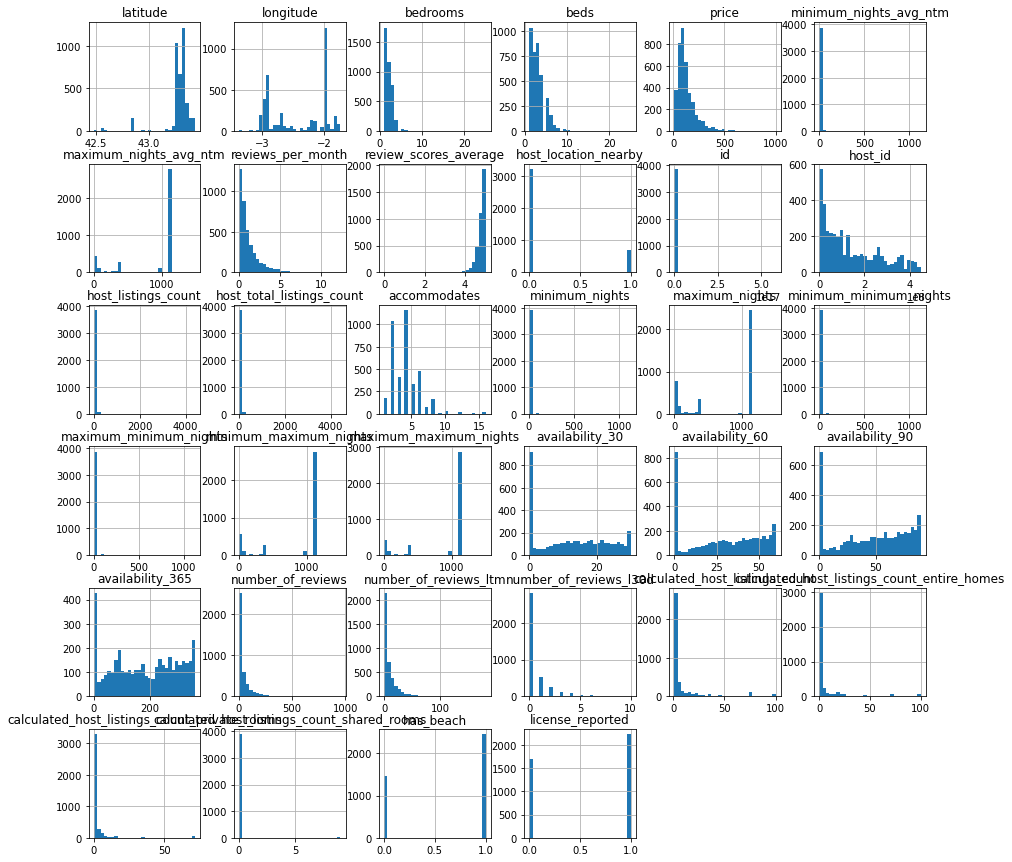

In [593]:
df[numerical_cols].hist(bins=30, figsize=(15,15));

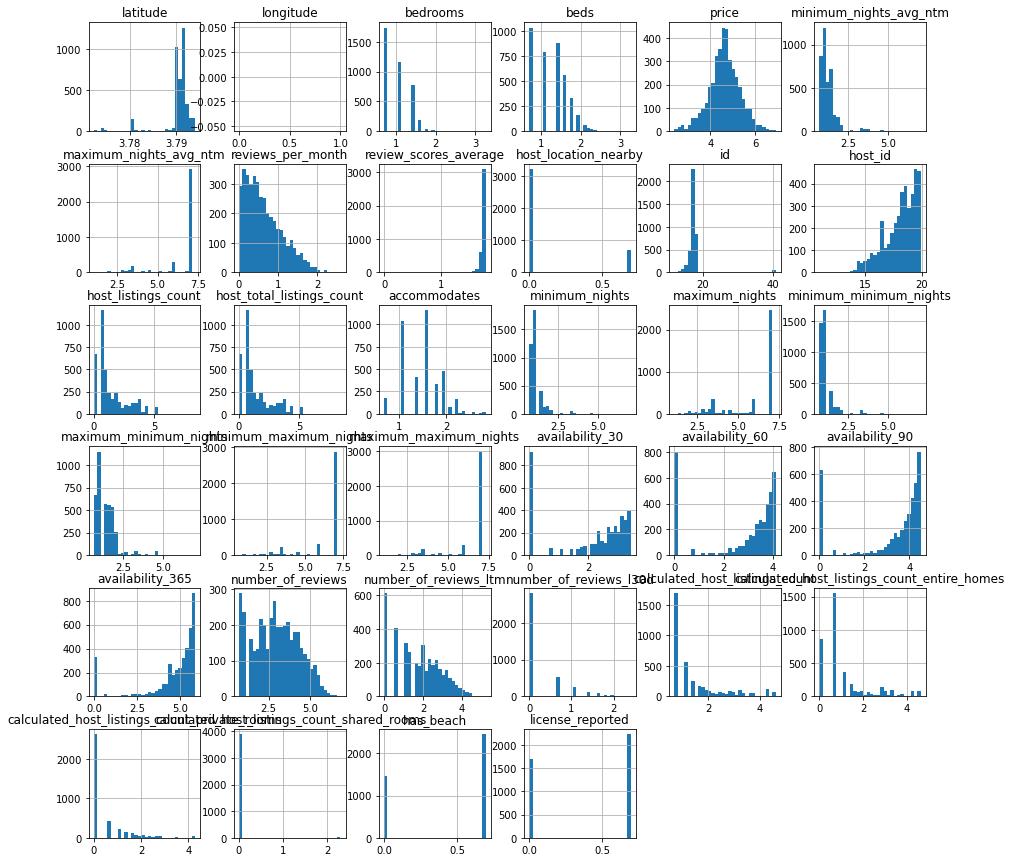

In [594]:
# Logarithmic transformation to have a first glance
# Some distributions seem to be more bell-shaped
# Note that we need to add 1 to deal with 0 values, since log(0) = -inf; log1p(x) == log(x+1)
np.log1p(df[numerical_cols]).hist(bins=30, figsize=(15,15));

#### Scatterplots & Selection of Transformations

/Users/mxagar/opt/anaconda3/envs/ds/lib/python3.7/site-packages/numpy/core/_methods.py:232: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/Users/mxagar/opt/anaconda3/envs/ds/lib/python3.7/site-packages/numpy/core/_methods.py:243: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/Users/mxagar/opt/anaconda3/envs/ds/lib/python3.7/site-packages/scipy/stats/morestats.py:1557: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(trans.var(axis=0))
/Users/mxagar/opt/anaconda3/envs/ds/lib/python3.7/site-packages/scipy/optimize/optimize.py:2216: RuntimeWarning: invalid value encountered in double_scalars
  p = (x - v) * tmp2 - (x - w) * tmp1
/Users/mxagar/opt/anaconda3/envs/ds/lib/python3.7/site-packages/scipy/optimize/optimize.py:2217: RuntimeWarning: invalid value encountered in double_scalars
  tmp2 = 2.0 * (tmp2 - tmp1)
/Users/mxagar/opt/anaconda3/envs/ds/lib

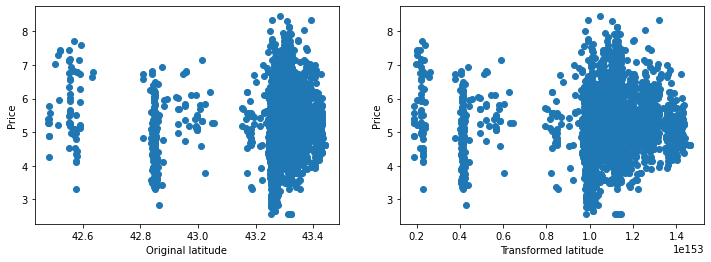

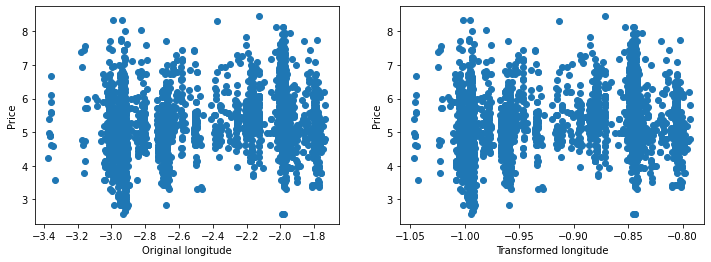

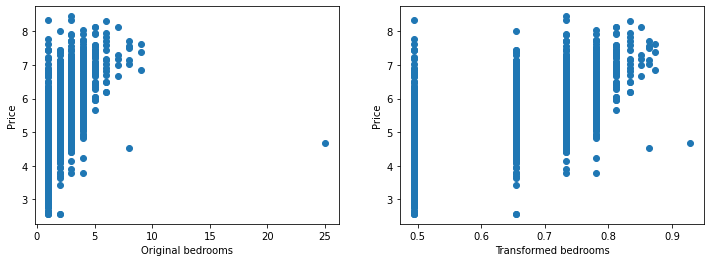

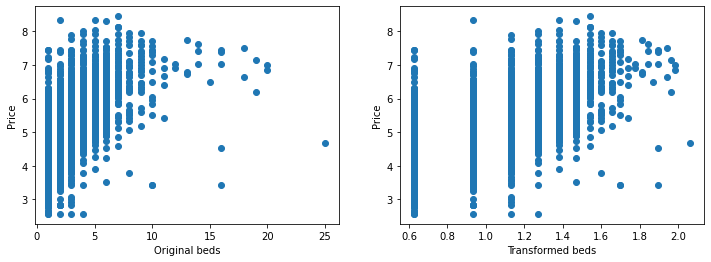

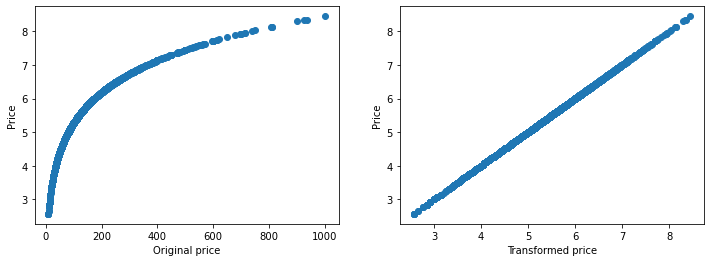

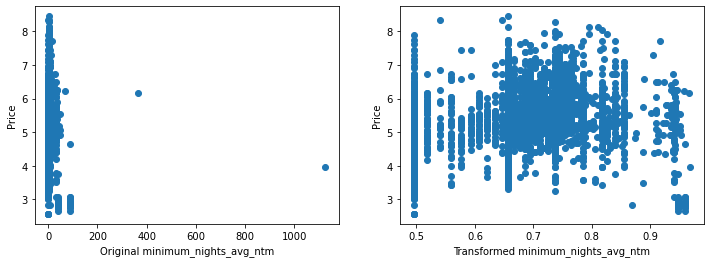

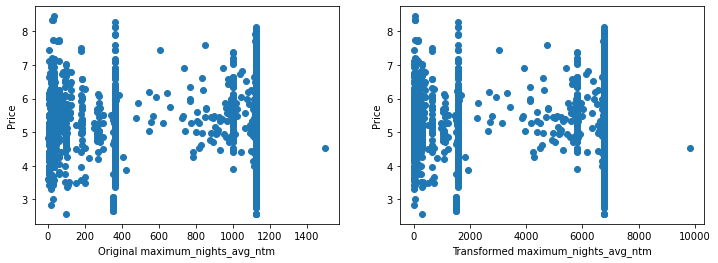

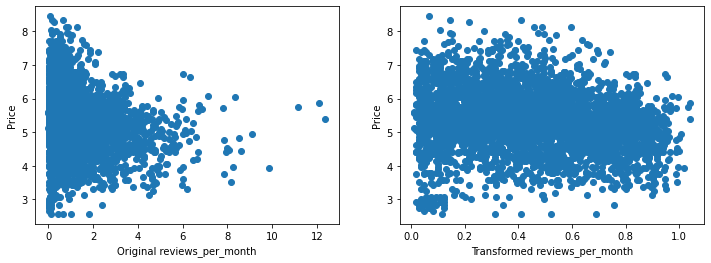

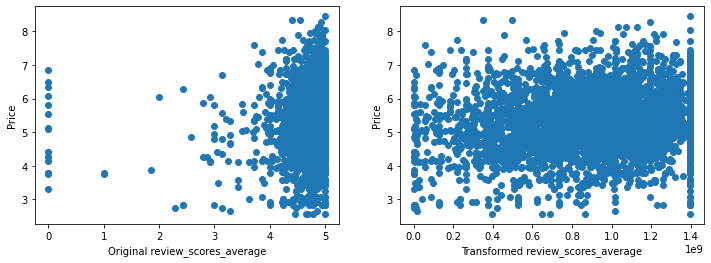

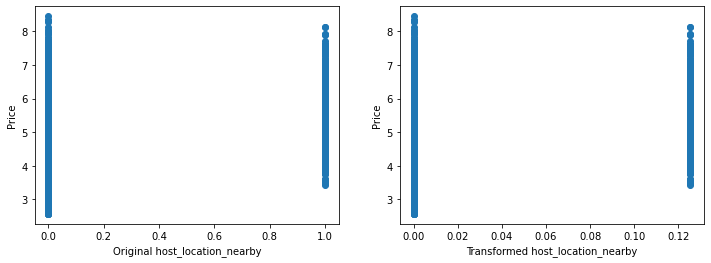

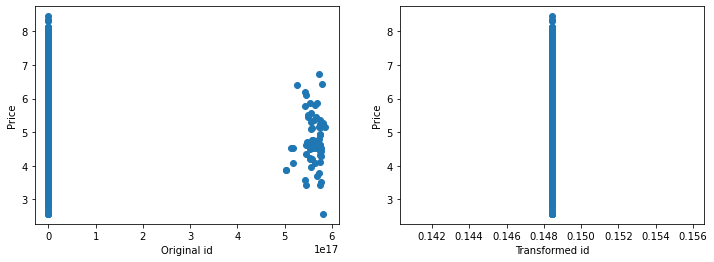

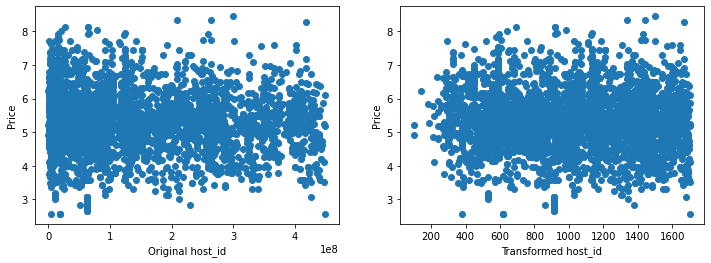

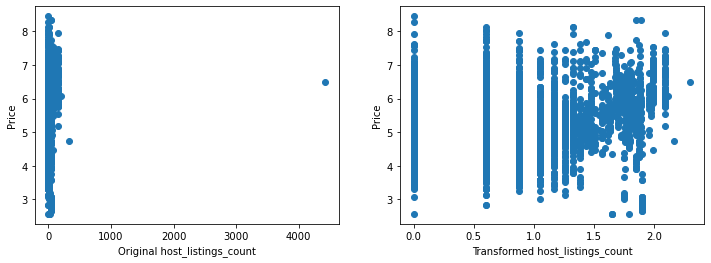

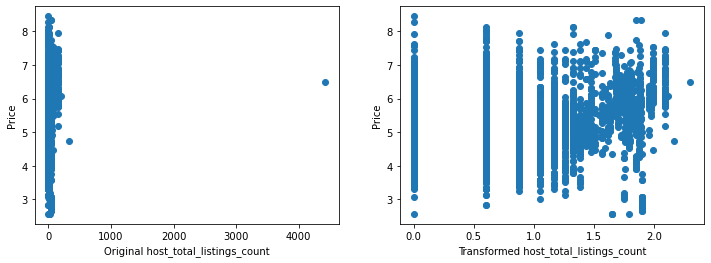

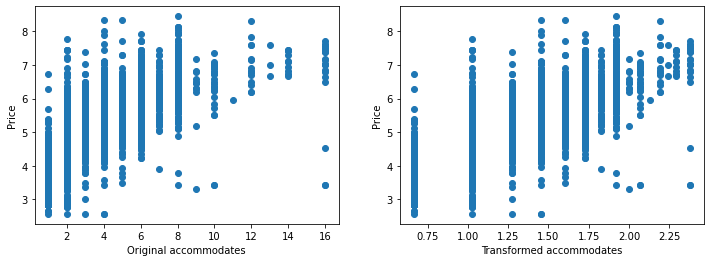

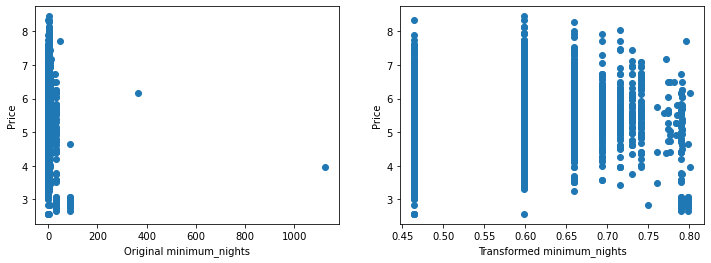

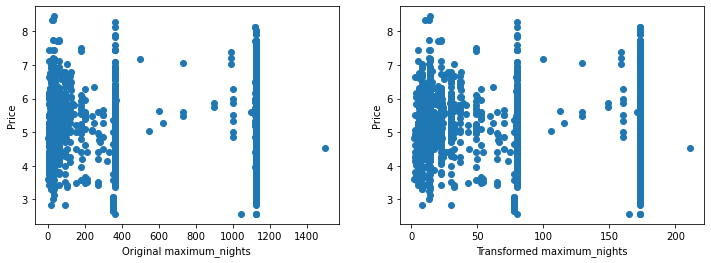

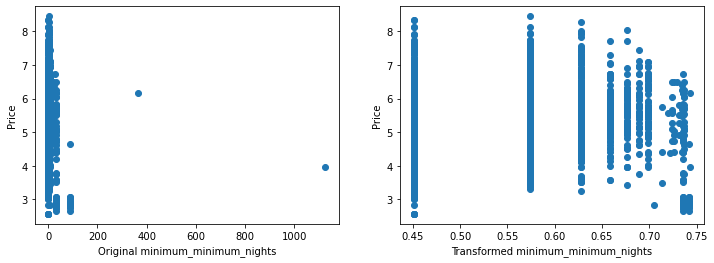

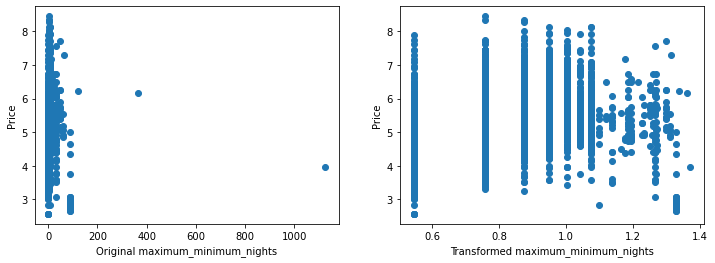

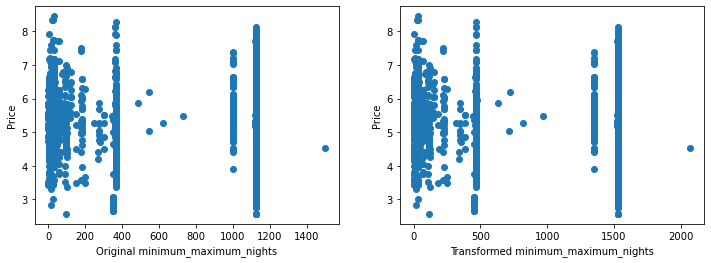

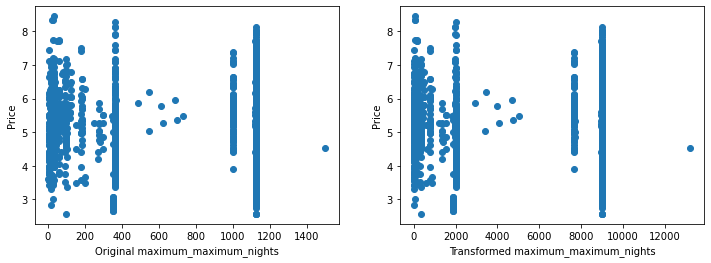

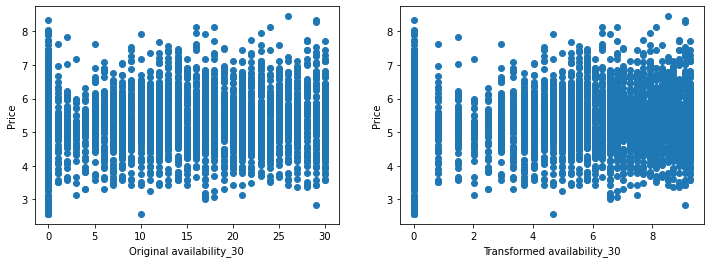

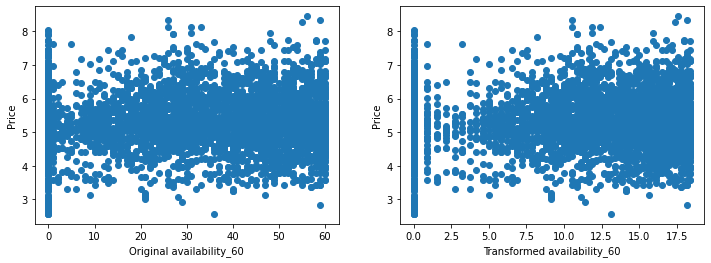

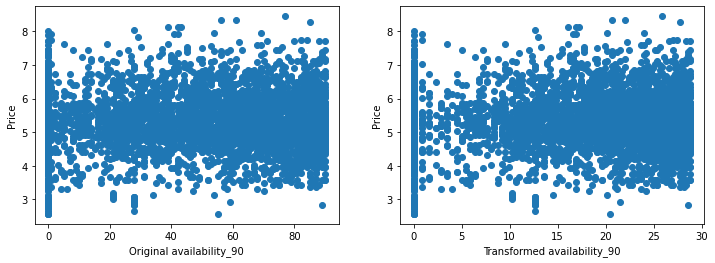

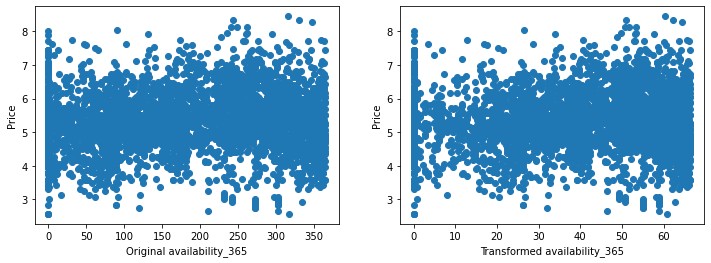

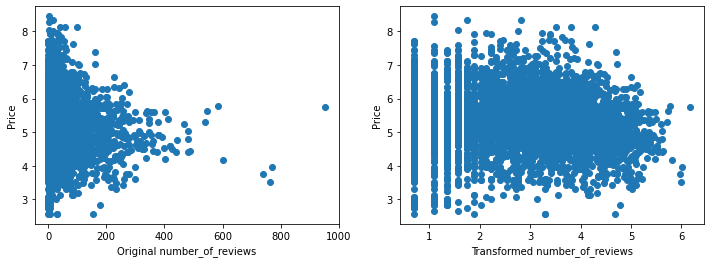

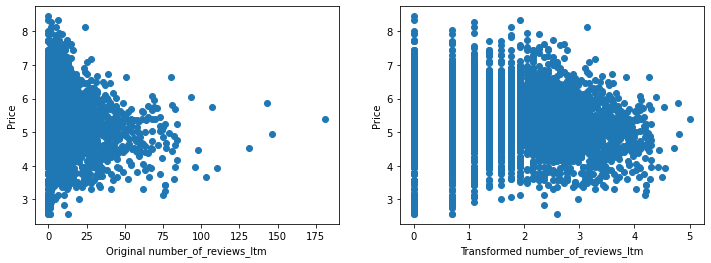

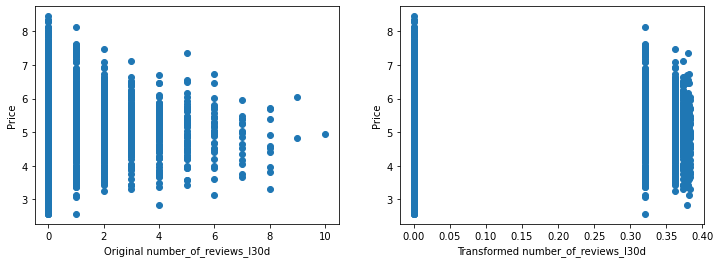

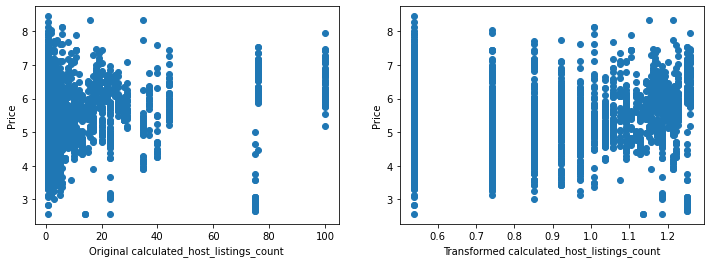

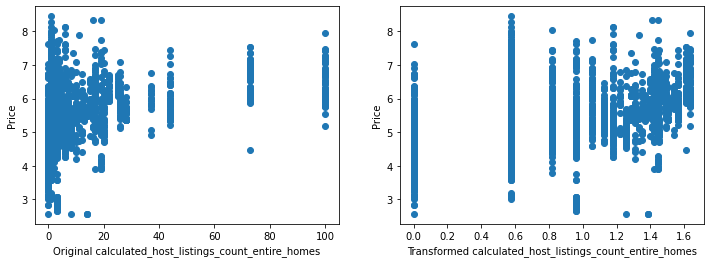

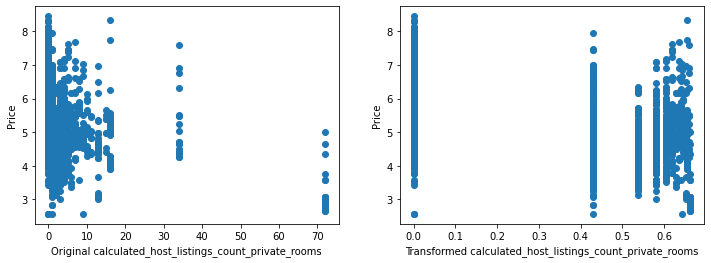

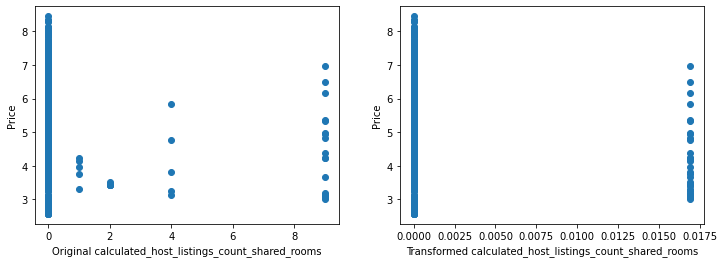

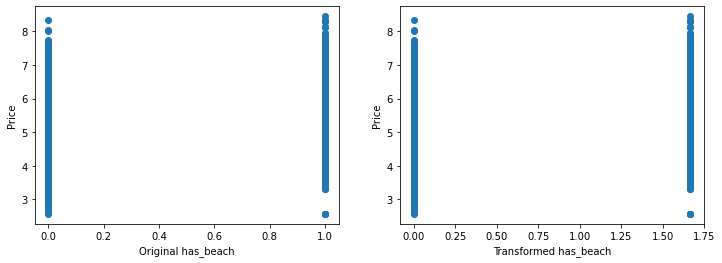

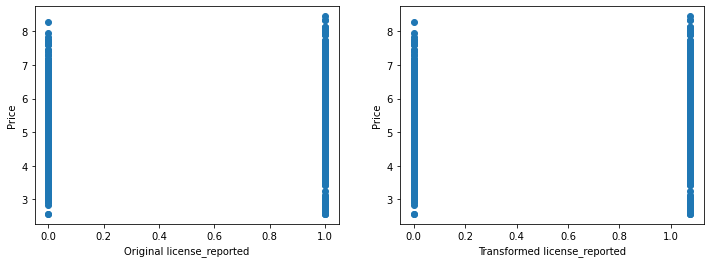

In [595]:
# Selection of candidates for a logarithmic-family transoformation.
# I choose the Yeo-Johnson transformation.
# The selection is done visually: the scatterplots variable-target are better when
# - larger spread
# - homogeneous density
# In the following, numerical variables are classified in subgroups
# after the visual inspection of the plots

# Numerical variables that are categorical
numerical_categorical = [
    'host_location_nearby',
    'has_beach',
    'license_reported'
]

# Numerical variables that will be binarized
numerical_binarized = ['calculated_host_listings_count_shared_rooms']

# Variables kept for transformation
numerical_transform = [
     'bedrooms',
     'beds',
     'price',
     'minimum_nights_avg_ntm',
     'maximum_nights_avg_ntm',
     'reviews_per_month',
     'host_total_listings_count',
     'accommodates',
     'minimum_nights',
     'maximum_nights',
     'minimum_minimum_nights',
     'maximum_minimum_nights',
     'minimum_maximum_nights',
     'maximum_maximum_nights',
     'number_of_reviews',
     'number_of_reviews_ltm',
     'calculated_host_listings_count',
     'calculated_host_listings_count_entire_homes',
     'calculated_host_listings_count_private_rooms'
]

# Numerical variables left as they are (acceptable distribution)
numerical_other = [
    'latitude',
    'longitude',
    'review_scores_average',
    'availability_30',
    'availability_60',
    'availability_90',
    'availability_365'
    'number_of_reviews_l30d'
]

# Now, all numerical variables are distributed like this:
# numerical_cols = numerical_cols_drop + numerical_categorical + numerical_binarized + numerical_transform + numerical_other

# Temporary copy of the data
# with transformed variables
tmp = df.copy()
price_transformed, _ = stats.yeojohnson(df['price'])

for var in numerical_cols:
    
    # transform the variable - yeo-johsnon
    tmp[var], param = stats.yeojohnson(df[var])
    
    plt.figure(figsize=(12,4))
    
    # plot the original variable vs sale price    
    plt.subplot(1, 2, 1)
    #plt.scatter(df[var], np.log1p(df['price']))
    plt.scatter(df[var], price_transformed)
    plt.ylabel('Price')
    plt.xlabel('Original ' + var)

    # plot transformed variable vs sale price
    plt.subplot(1, 2, 2)
    #plt.scatter(np.log1p(df[var]), np.log1p(df['price']))
    plt.scatter(tmp[var], price_transformed)
    plt.ylabel('Price')
    plt.xlabel('Transformed ' + var)

#### Correlations

Text(0.5, 1.0, 'Correlations of numerical variables')

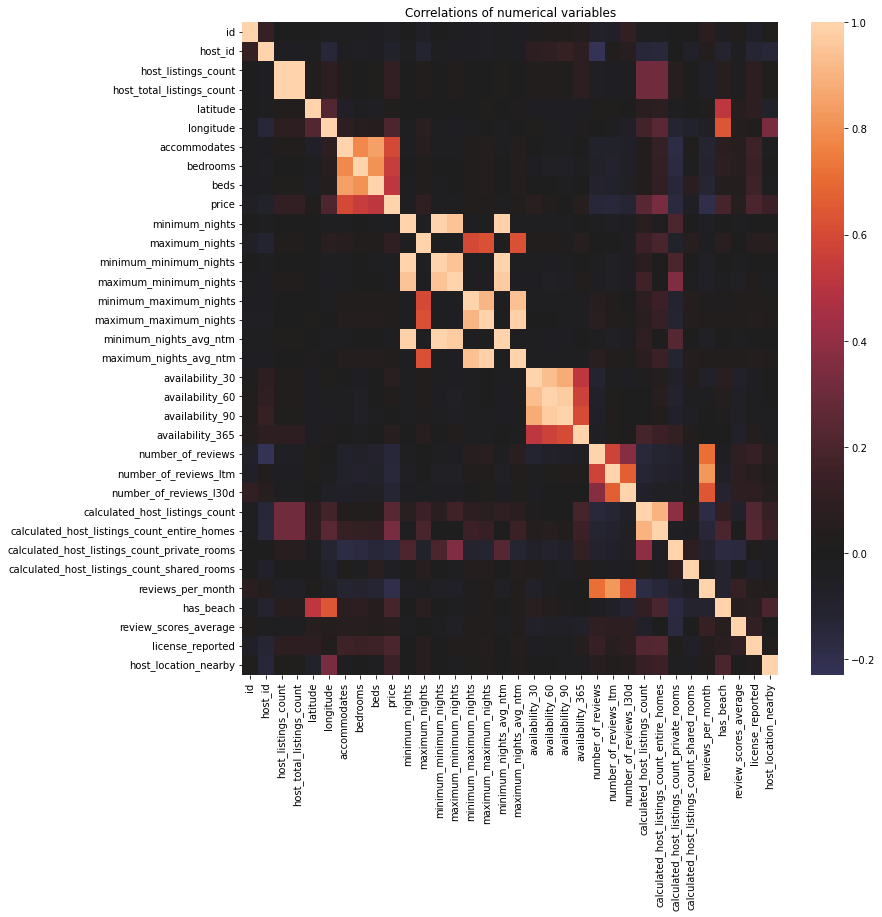

In [596]:
# There are not large correlations; notes:
# - Beds (or bedrooms) & price are related, as expected
# - Beach and long & lat coordinates are related, as expected
# - Review don't seem to correlated with any numerical variable
# - Hosts with more listings seem to have higher prices
plt.figure(figsize=(12,12))
sns.heatmap(df.corr(),center=0.0)
plt.title('Correlations of numerical variables')

In [597]:
# Correlations of numerical variables with the price
# The majority of the variables have a correlation smaller than 0.15
df.corr()['price'].sort_values()

reviews_per_month                              -0.194618
calculated_host_listings_count_private_rooms   -0.159387
number_of_reviews_ltm                          -0.150747
number_of_reviews                              -0.141959
number_of_reviews_l30d                         -0.124032
host_id                                        -0.086160
id                                             -0.060275
calculated_host_listings_count_shared_rooms    -0.050648
maximum_minimum_nights                         -0.035586
minimum_minimum_nights                         -0.034134
minimum_nights                                 -0.031889
minimum_nights_avg_ntm                         -0.029102
availability_90                                 0.006740
latitude                                        0.015553
minimum_maximum_nights                          0.029643
availability_60                                 0.032695
maximum_maximum_nights                          0.038449
maximum_nights_avg_ntm         

<AxesSubplot:>

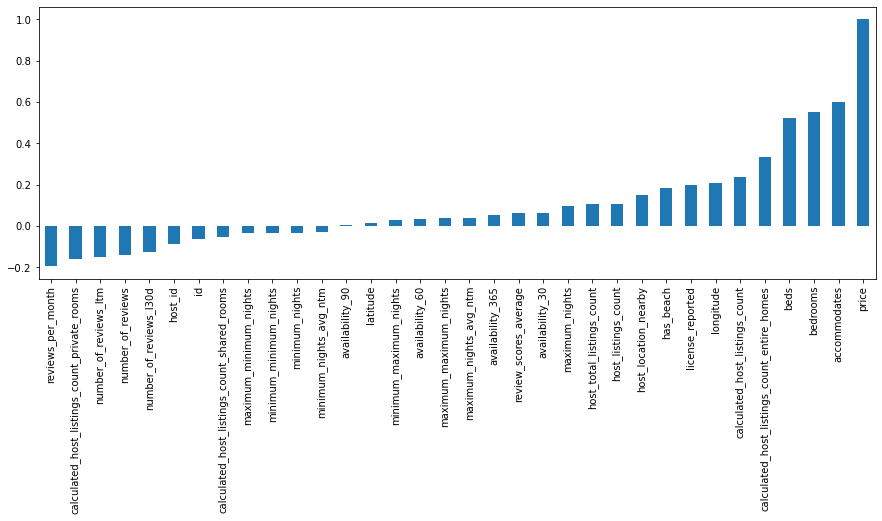

In [598]:
plt.figure(figsize=(15,5))
df.corr()['price'].sort_values().plot(kind='bar')

In [599]:
# The most relevant variables that show a larger correlation with the price
price_correlations = df.corr()['price']
price_correlation_variables = list(price_correlations[(price_correlations >= 0.15) | (price_correlations <= -0.15)].index)
price_correlation_variables

['longitude',
 'accommodates',
 'bedrooms',
 'beds',
 'price',
 'number_of_reviews_ltm',
 'calculated_host_listings_count',
 'calculated_host_listings_count_entire_homes',
 'calculated_host_listings_count_private_rooms',
 'reviews_per_month',
 'has_beach',
 'license_reported']

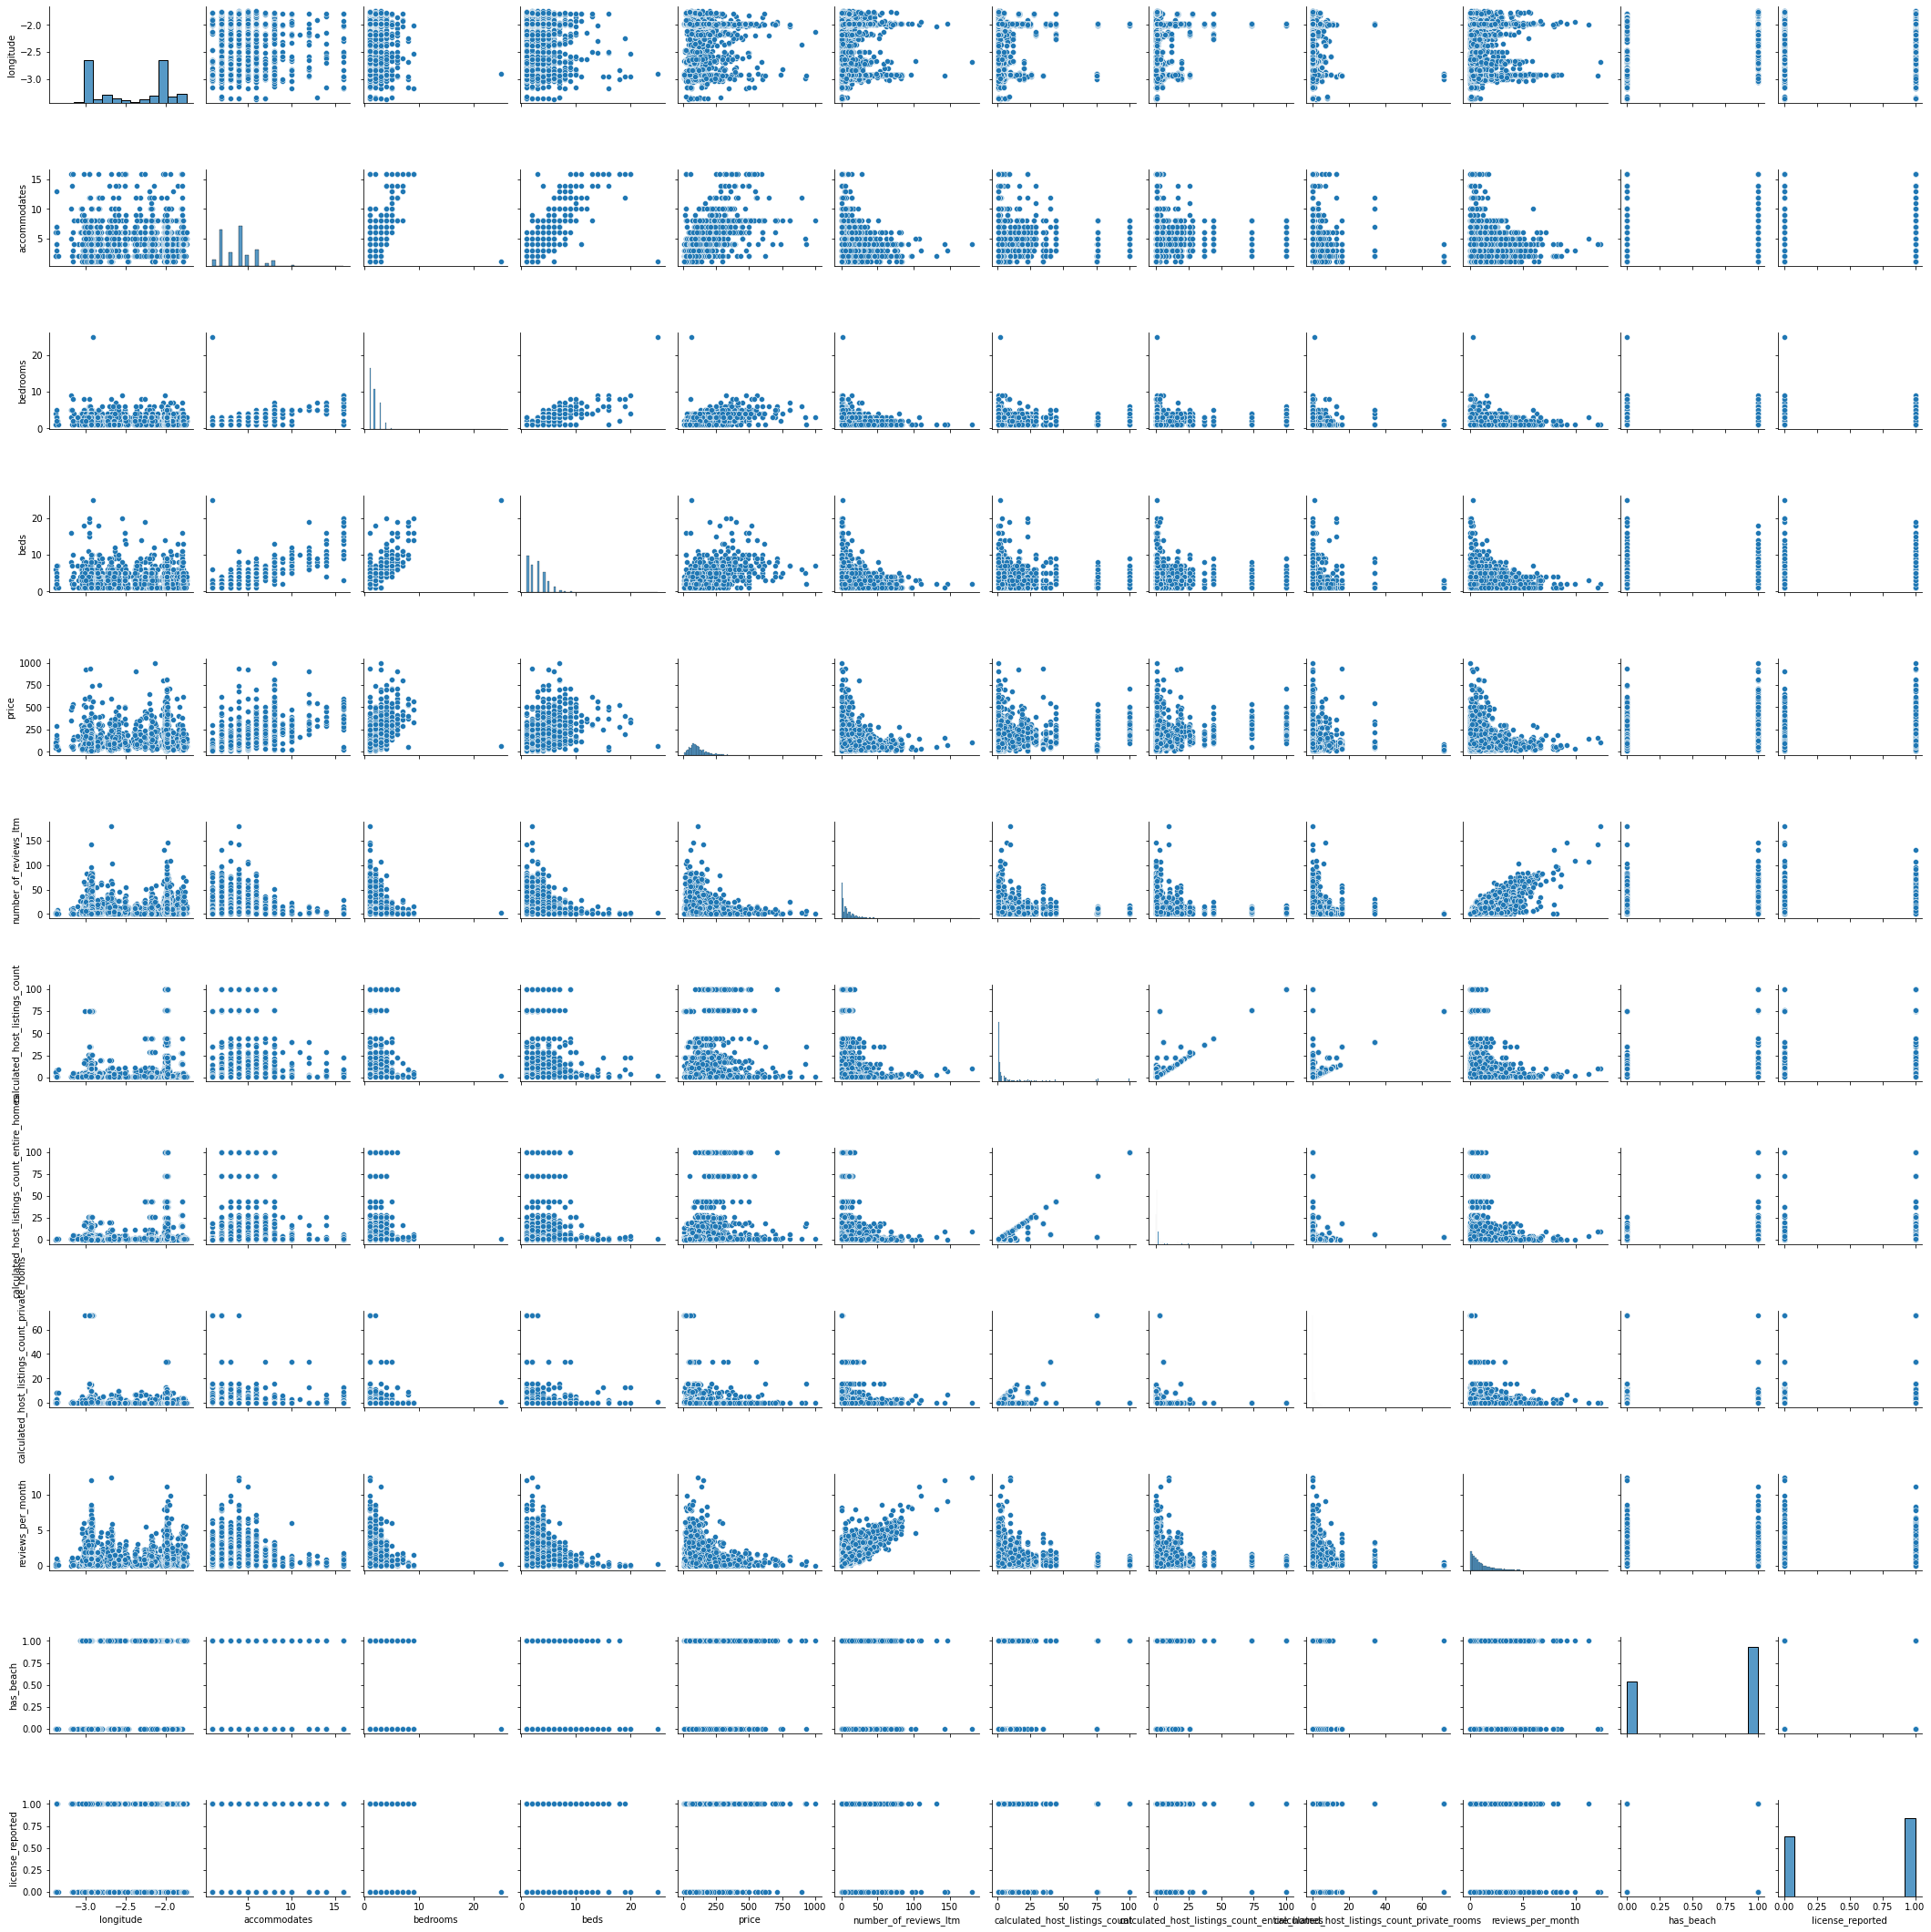

In [600]:
sns.pairplot(df[price_correlation_variables])

In [601]:
# The correlations of the numerical features with the average review score
# are much lower
df.corr()['review_scores_average'].sort_values()

calculated_host_listings_count_private_rooms   -0.155829
calculated_host_listings_count                 -0.078482
availability_365                               -0.076199
availability_30                                -0.075886
availability_90                                -0.065571
availability_60                                -0.063085
maximum_minimum_nights                         -0.053725
minimum_nights_avg_ntm                         -0.037275
minimum_minimum_nights                         -0.034130
minimum_nights                                 -0.032518
host_id                                        -0.031499
host_listings_count                            -0.025566
host_total_listings_count                      -0.025566
calculated_host_listings_count_shared_rooms    -0.011188
calculated_host_listings_count_entire_homes    -0.011153
host_location_nearby                           -0.010394
maximum_nights                                  0.002328
minimum_maximum_nights         

<AxesSubplot:>

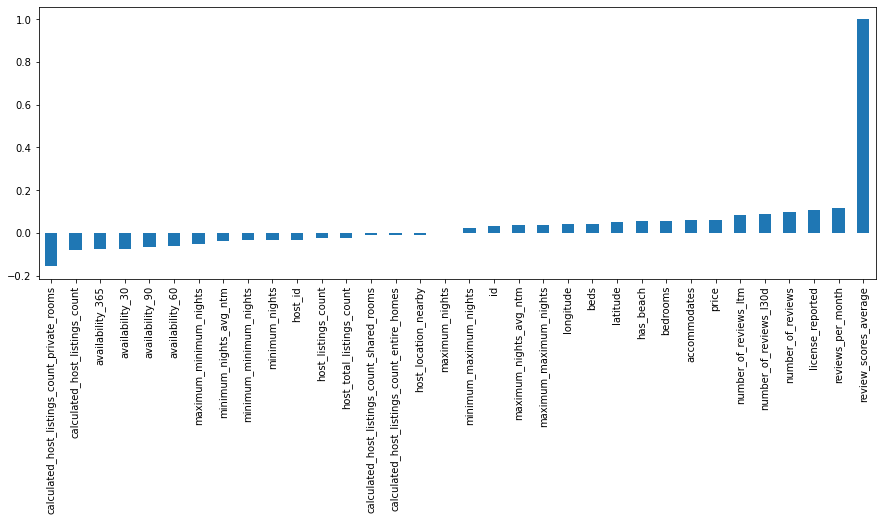

In [602]:
plt.figure(figsize=(15,5))
df.corr()['review_scores_average'].sort_values().plot(kind='bar')

#### Distribution of Price & Reviews Depending on Access to Beach

Text(0.5, 1.0, 'Price distribution depending on access to beach')

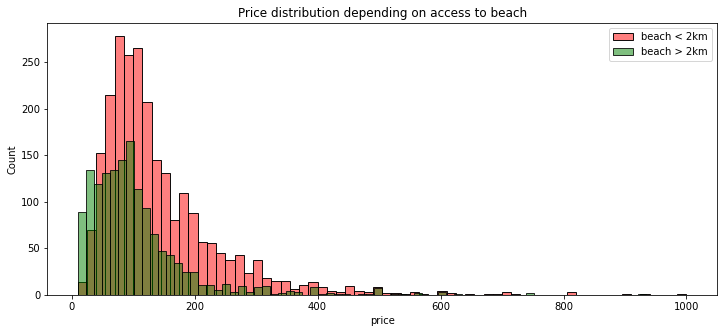

In [603]:
# Access to beach leads to a slightly different price distribution
plt.figure(figsize=(12,5))
sns.histplot(df[df.has_beach == 1].price,color='red',alpha=0.5)
sns.histplot(df[df.has_beach == 0].price,color='green',alpha=0.5)
plt.legend(['beach < 2km', 'beach > 2km'])
plt.title('Price distribution depending on access to beach')

Text(0.5, 1.0, 'Average review score distribution depending on access to beach')

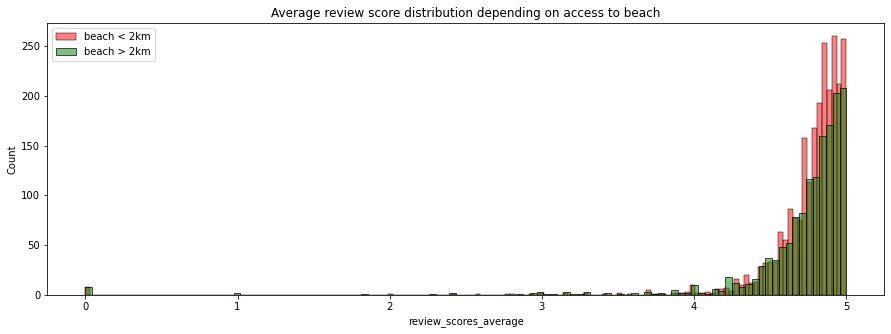

In [604]:
# Access to beach doesn't seem to be related to different review distirbutions
plt.figure(figsize=(15,5))
sns.histplot(df[df.has_beach == 1].review_scores_average,color='red',alpha=0.5)
sns.histplot(df[df.has_beach == 0].review_scores_average,color='green',alpha=0.5)
plt.legend(['beach < 2km', 'beach > 2km'])
plt.title('Average review score distribution depending on access to beach')

#### Distribution of Price & Reviews Depending on Major Cities

In [605]:
df['neighbourhood_cleansed'].value_counts()[:3]

Donostia-San Sebastian    1292
Bilbao                     940
Zarautz                    155
Name: neighbourhood_cleansed, dtype: int64

Text(0.5, 1.0, 'Price distribution depending on city')

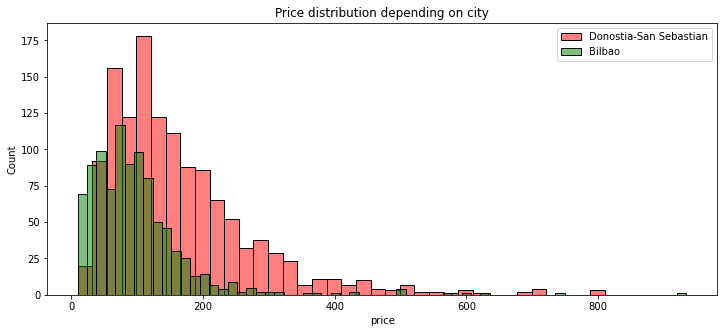

In [606]:
# Two major cities have slightly different price distributions
plt.figure(figsize=(12,5))
sns.histplot(df[df.neighbourhood_cleansed == "Donostia-San Sebastian"].price,color='red',alpha=0.5)
sns.histplot(df[df.neighbourhood_cleansed == "Bilbao"].price,color='green',alpha=0.5)
plt.legend(['Donostia-San Sebastian', 'Bilbao'])
plt.title('Price distribution depending on city')

Text(0.5, 1.0, 'Average review score distribution depending on city')

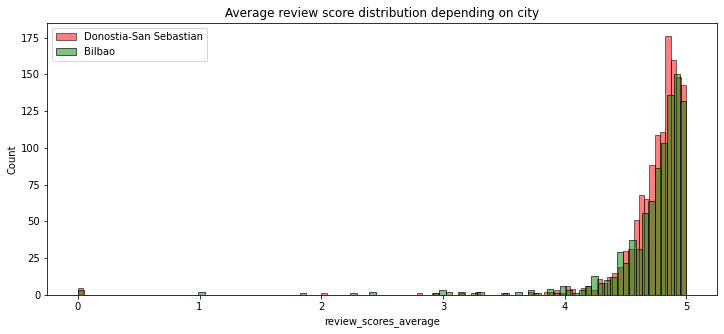

In [607]:
# Two major cities seem to have similar review score distributions
plt.figure(figsize=(12,5))
sns.histplot(df[df.neighbourhood_cleansed == "Donostia-San Sebastian"].review_scores_average,color='red',alpha=0.5)
sns.histplot(df[df.neighbourhood_cleansed == "Bilbao"].review_scores_average,color='green',alpha=0.5)
plt.legend(['Donostia-San Sebastian', 'Bilbao'])
plt.title('Average review score distribution depending on city')

#### Numerical Variables that Are Discrete (Cardinal Data)

These variables are detected as numerical, but are discrete by definition. I keep them as numerical (since they are cardinal), but plot some boxplots to get an idea of what is happening with them.

- `beds`
- `bedrooms`
- `accommodates`

<AxesSubplot:xlabel='beds', ylabel='price'>

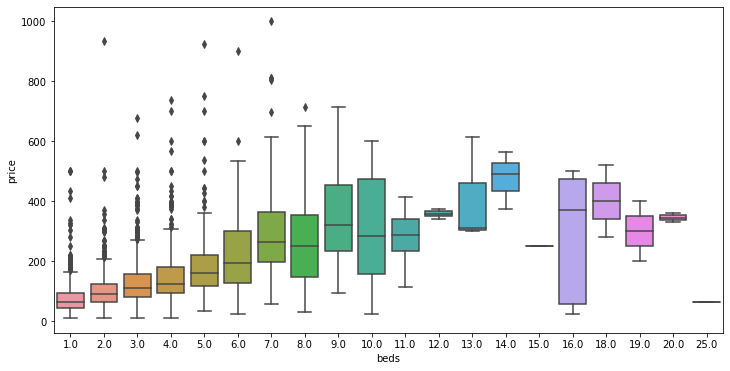

In [608]:
# There seems to be a tendency to spread the price distribution upwards
# as the number of beds increases
plt.figure(figsize=(12,6))
sns.boxplot(x=df['beds'],y=df['price'])

<AxesSubplot:xlabel='bedrooms', ylabel='price'>

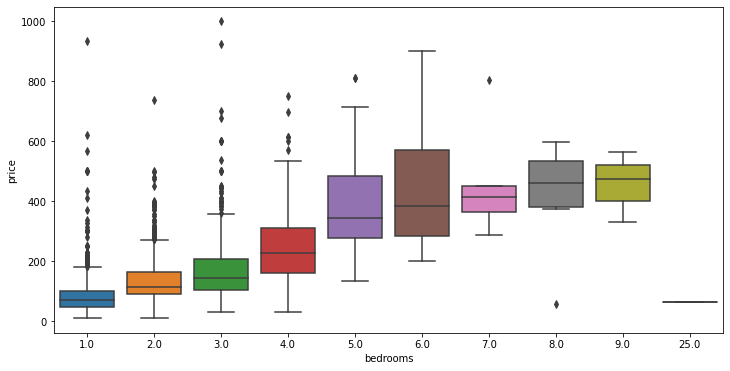

In [609]:
# There seems to be a tendency to spread the price distribution upwards
# as the number of bedrooms increases
plt.figure(figsize=(12,6))
sns.boxplot(x=df['bedrooms'],y=df['price'])

<AxesSubplot:xlabel='accommodates', ylabel='price'>

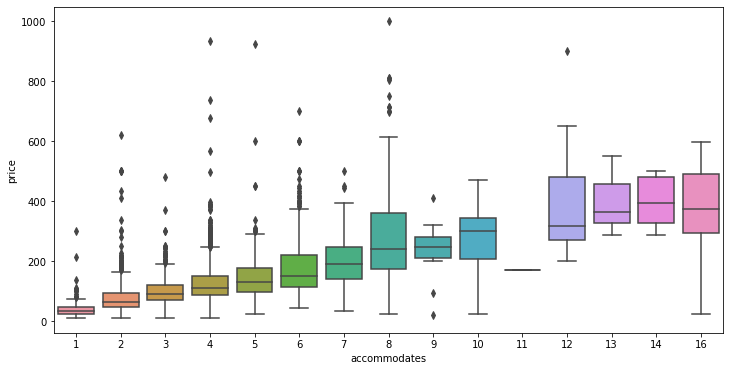

In [610]:
# There seems to be a tendency to spread the price distribution upwards
# as the maximum capacity of the listing (=accommodates) increases
plt.figure(figsize=(12,6))
sns.boxplot(x=df['accommodates'],y=df['price'])

#### Price Display in Coordinates Scatterplot (Longitude & Latitude)

In [611]:
df['price'].describe()

count    3931.000000
mean      128.197660
std        99.048393
min        10.000000
25%        70.000000
50%       100.000000
75%       155.000000
max      1000.000000
Name: price, dtype: float64

In [612]:
# Quantile / Percentile: 90%
# Since the price distirbution has a long right tail, we take the 90% percentile
# as threshold to plot the property location prices encoded with color;
# otherwise, all prices are very low compared to the maximum value and we cannot distinguish any details
df['price'].quantile(0.9)

243.0

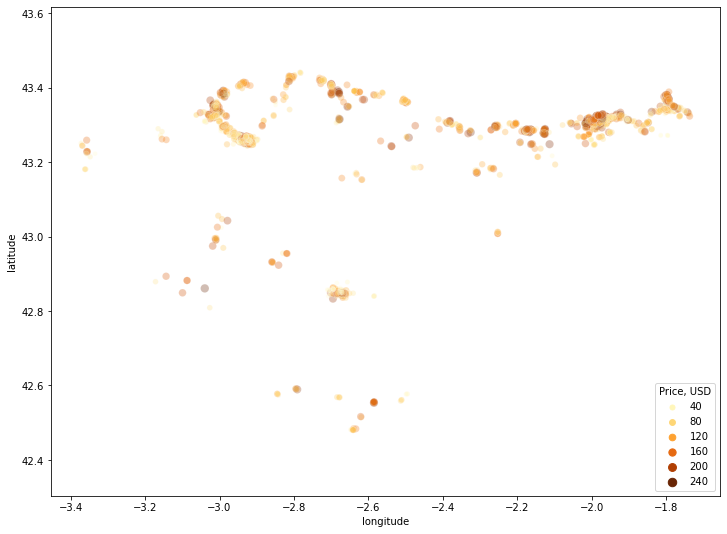

In [613]:
# Property coordinates and their prices enconded with color
# Only properties with access to a beach (< 2km) are considered
#df.plot.scatter(x='longitude',y='latitude',c='price',cmap='coolwarm',figsize=(12,8.5))
threshold = df['price'].quantile(0.9)
plt.figure(figsize=(12,9))
plt.axis('equal')
sns.scatterplot(data=df[df.price < threshold],x='longitude',y='latitude',hue='price',palette='YlOrBr',alpha=0.3,size='price')
#sns.scatterplot(data=df[(df.has_beach > 0) & (df.price < threshold)],x='longitude',y='latitude',hue='price',palette='YlOrBr',alpha=0.3,size='price')
plt.legend(loc='lower right',title='Price, USD')

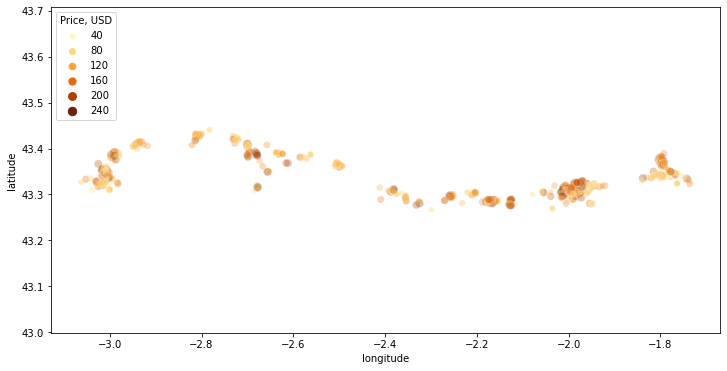

In [614]:
# Property coordinates and their prices enconded with color
# Only properties with access to a beach (< 2km) are considered
#df.plot.scatter(x='longitude',y='latitude',c='price',cmap='coolwarm',figsize=(12,8.5))
threshold = df['price'].quantile(0.9)
plt.figure(figsize=(12,6))
plt.axis('equal')
#sns.scatterplot(data=df[df.price < threshold],x='longitude',y='latitude',hue='price',palette='YlOrBr',alpha=0.3,size='price')
sns.scatterplot(data=df[(df.has_beach > 0) & (df.price < threshold)],x='longitude',y='latitude',hue='price',palette='YlOrBr',alpha=0.3,size='price')
plt.legend(loc='upper left',title='Price, USD')

### 3.3 Categorical/Discrete Variables

#### Get Number of Categories

In [615]:
# Get a list of all categorical variables
categorical_cols = categorical_cols + numerical_categorical
categorical_cols

['name',
 'listing_url',
 'description',
 'host_name',
 'host_since',
 'host_response_time',
 'host_response_rate',
 'host_acceptance_rate',
 'host_is_superhost',
 'host_verifications',
 'host_has_profile_pic',
 'host_identity_verified',
 'neighbourhood_cleansed',
 'neighbourhood_group_cleansed',
 'property_type',
 'room_type',
 'bathrooms_text',
 'amenities',
 'has_availability',
 'first_review',
 'last_review',
 'instant_bookable',
 'host_location_nearby',
 'has_beach',
 'license_reported']

In [616]:
# Get number of unique values for each category = categories
for col in categorical_cols:
    print(f'{col}: {len(df[col].unique())}')

name: 3903
listing_url: 3931
description: 3816
host_name: 1075
host_since: 1622
host_response_time: 4
host_response_rate: 37
host_acceptance_rate: 79
host_is_superhost: 2
host_verifications: 134
host_has_profile_pic: 2
host_identity_verified: 2
neighbourhood_cleansed: 59
neighbourhood_group_cleansed: 3
property_type: 54
room_type: 4
bathrooms_text: 35
amenities: 3693
has_availability: 2
first_review: 1520
last_review: 645
instant_bookable: 2
host_location_nearby: 2
has_beach: 2
license_reported: 2


In [617]:
# Categorical variables with large unique values
# host_response_rate and host_acceptance_rate can be converted to numerical
# property_type needs to be encoded
for col in ['host_response_rate','host_acceptance_rate','property_type']:
    print(f'{col}: \n{df[col].unique()}\n')

host_response_rate: 
['100%' '67%' '88%' '0%' '90%' '75%' '99%' '57%' '96%' '95%' '83%' '40%'
 '80%' '93%' '91%' '60%' '97%' '50%' '86%' '33%' '89%' '82%' '71%' '92%'
 '25%' '94%' '70%' '74%' '20%' '63%' '78%' '64%' '98%' '29%' '73%' '44%'
 '85%']

host_acceptance_rate: 
['100%' '97%' '0%' '98%' '64%' '83%' '95%' '80%' '96%' '67%' '71%' '77%'
 '18%' '60%' '29%' '19%' '65%' '47%' '99%' '74%' '43%' '76%' '14%' '66%'
 '33%' '50%' '93%' '89%' '87%' '91%' '75%' '88%' '78%' '73%' '79%' '1%'
 '86%' '25%' '69%' '84%' '92%' '63%' '82%' '51%' '94%' '90%' '11%' '40%'
 '58%' '81%' '62%' '15%' '68%' '44%' '41%' '57%' '24%' '46%' '59%' '85%'
 '31%' '28%' '54%' '22%' '38%' '42%' '20%' '17%' '72%' '55%' '32%' '70%'
 '56%' '36%' '61%' '27%' '3%' '52%' '30%']

property_type: 
['Entire condo' 'Private room in rental unit' 'Entire rental unit'
 'Entire home' 'Entire villa' 'Entire loft' 'Private room in hostel'
 'Private room in home' 'Private room in townhouse' 'Entire cottage'
 'Entire guest suite' 'Pri

#### Boxplots of Categoricals with Few Categories

In [618]:
# Most of the categorical variables need to be processed manually
# when doing feature engineering.
# Here, I display box plots of the ones that are readily available.
categorcial_selected = [
    'host_response_time',
    'host_is_superhost',
    'host_has_profile_pic',
    'host_identity_verified',
    'neighbourhood_group_cleansed',
    'room_type',
    'has_availability',
    'instant_bookable',
    'host_location_nearby',
    'has_beach',
    'license_reported'
]

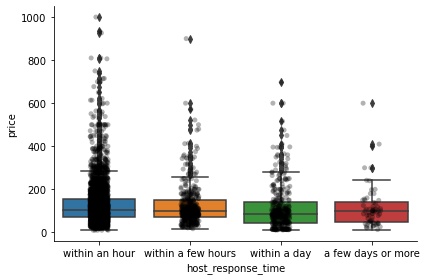

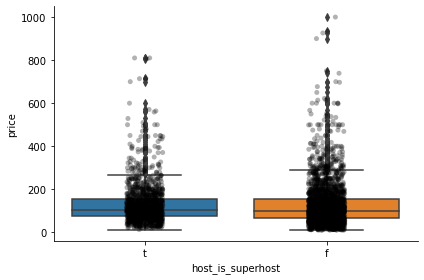

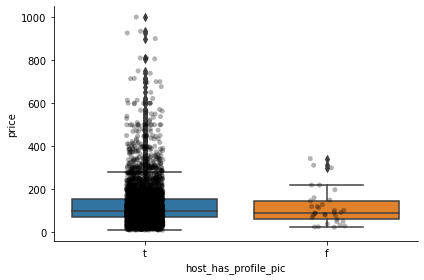

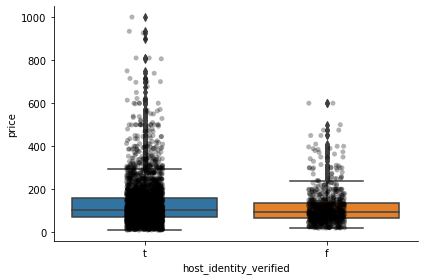

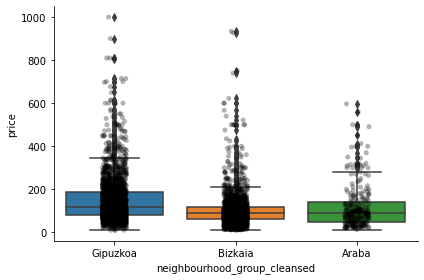

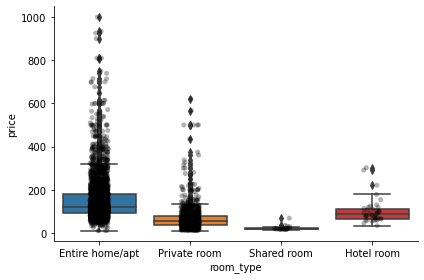

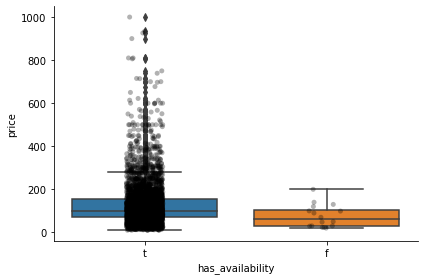

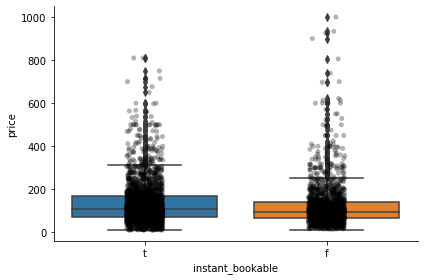

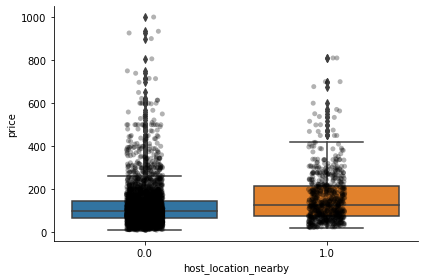

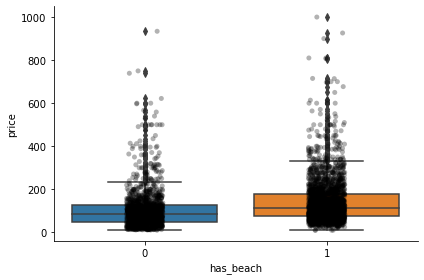

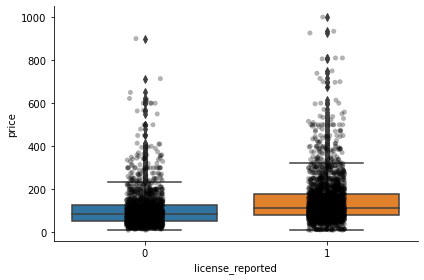

In [619]:
# Boxplots of categorcial variables
for var in categorcial_selected:
    sns.catplot(x=var, y='price', data=df, kind="box", height=4, aspect=1.5)
    # Data points
    sns.stripplot(x=var, y='price', data=df, jitter=0.1, alpha=0.3, color='k')
    plt.show()

#### Encoding/Mapping of Categories

In [620]:
# Some categorcial variables are binary and their category values
# should be mapped from (t,f) -> (1,0)
binary_mappings = {'t': 1, 'f': 0}
binary_vars = [
    'host_is_superhost',
    'host_has_profile_pic',
    'host_identity_verified',
    'has_availability',
    'instant_bookable'
]
for var in binary_vars:
    df[var] = df[var].map(binary_mappings)

In [621]:
# Similarly, the categories of some variables are mapped
# for a an easier handling when they are converted to dummies
df['host_response_time'].unique()

array(['within an hour', 'within a few hours', 'within a day',
       'a few days or more'], dtype=object)

In [622]:
df['host_response_time'].replace({"within an hour":'hour',
                                  "within a few hours":'few_hours',
                                  "within a day":'day',
                                  "a few days or more":'few_days'},inplace=True)

In [623]:
df['room_type'].unique()

array(['Entire home/apt', 'Private room', 'Shared room', 'Hotel room'],
      dtype=object)

In [624]:
df['room_type'].replace({"Entire home/apt":'home',
                         "Private room":'room_private',
                         "Shared room":'room_shared',
                         "Hotel room":'room_hotel'},inplace=True)

In [625]:
df['room_type'].unique()

array(['home', 'room_private', 'room_shared', 'room_hotel'], dtype=object)

In [626]:
# These variables are percentages encoded as strings:
# host_response_rate, host_acceptance_rate
try:
    for col in ['host_response_rate', 'host_acceptance_rate']:
        df[col] = df[col].apply(lambda pcnt: float(pcnt.split("%")[0])/100.0)
except AttributeError as err:
    print("Values already converted!")

In [627]:
df['host_response_rate'].describe()

count    3931.000000
mean        0.960107
std         0.138337
min         0.000000
25%         1.000000
50%         1.000000
75%         1.000000
max         1.000000
Name: host_response_rate, dtype: float64

In [628]:
df['host_acceptance_rate'].describe()

count    3931.000000
mean        0.905899
std         0.198402
min         0.000000
25%         0.920000
50%         1.000000
75%         1.000000
max         1.000000
Name: host_acceptance_rate, dtype: float64

#### Variables with Many Categories: Property Type

In [629]:
# property_type
list(df['property_type'].unique())

['Entire condo',
 'Private room in rental unit',
 'Entire rental unit',
 'Entire home',
 'Entire villa',
 'Entire loft',
 'Private room in hostel',
 'Private room in home',
 'Private room in townhouse',
 'Entire cottage',
 'Entire guest suite',
 'Private room in condo',
 'Private room in villa',
 'Entire guesthouse',
 'Shared room in hostel',
 'Private room in cottage',
 'Entire serviced apartment',
 'Private room in bed and breakfast',
 'Entire townhouse',
 'Room in aparthotel',
 'Private room',
 'Room in bed and breakfast',
 'Private room in boat',
 'Shared room in bed and breakfast',
 'Private room in camper/rv',
 'Private room in casa particular',
 'Shared room in farm stay',
 'Room in hostel',
 'Farm stay',
 'Private room in guesthouse',
 'Barn',
 'Floor',
 'Entire vacation home',
 'Entire chalet',
 'Private room in floor',
 'Private room in chalet',
 'Shared room in cottage',
 'Private room in guest suite',
 'Private room in loft',
 'Room in serviced apartment',
 'Private room in

<AxesSubplot:xlabel='price', ylabel='property_type'>

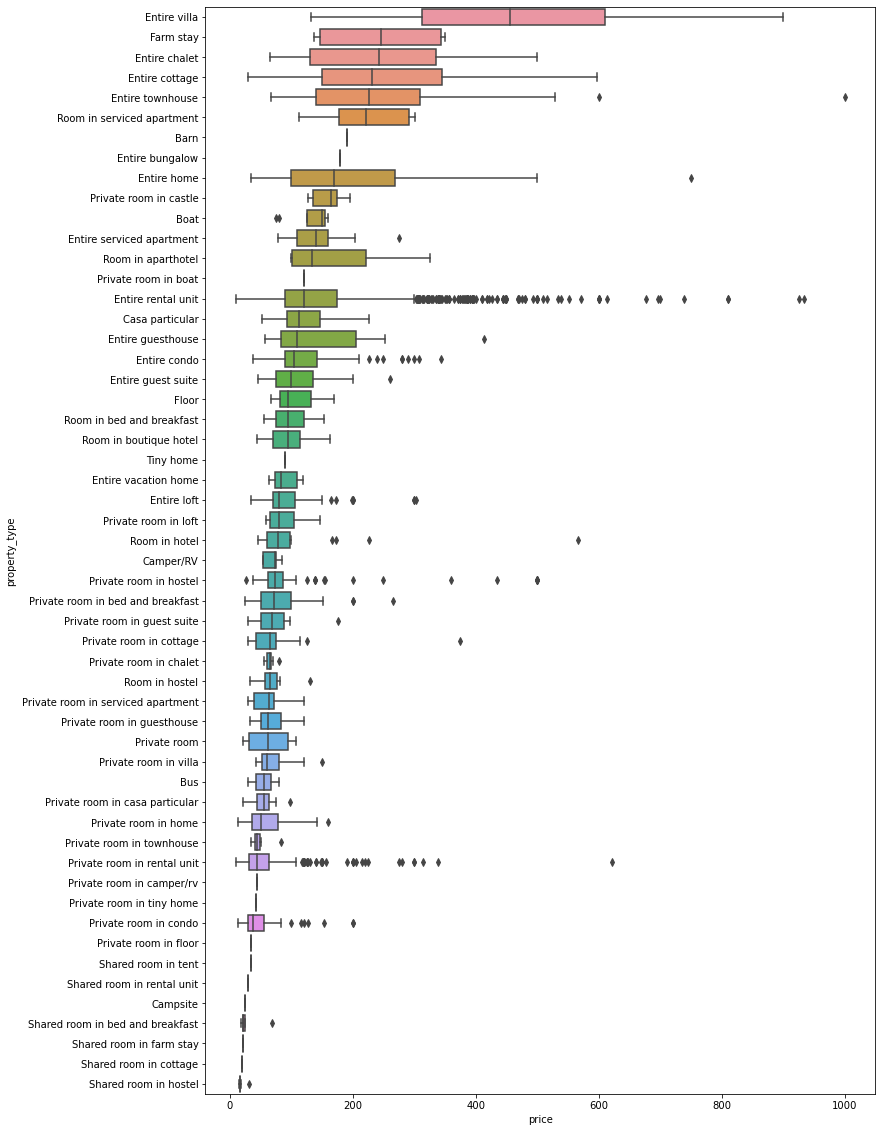

In [630]:
# There is a clear order in the categories defined in property_type
order = list(df.groupby('property_type')['price'].median().sort_values(ascending=False).index)
plt.figure(figsize=(12,20))
sns.boxplot(data=df,x='price',y='property_type',orient="h",order=order)

In order to have easier dummy names, we will enconde property types with ascending string numbers; the higher the number, the higher the expected median price of the property type. We will save a list and a dictionary which map the number and the original category name bidirectionally.

In [631]:
property_type_list = list(df.groupby('property_type')['price'].median().sort_values(ascending=True).index)

In [632]:
property_type_list

['Shared room in hostel',
 'Shared room in cottage',
 'Shared room in bed and breakfast',
 'Shared room in farm stay',
 'Campsite',
 'Shared room in rental unit',
 'Shared room in tent',
 'Private room in floor',
 'Private room in condo',
 'Private room in tiny home',
 'Private room in camper/rv',
 'Private room in rental unit',
 'Private room in townhouse',
 'Private room in home',
 'Bus',
 'Private room in casa particular',
 'Private room in villa',
 'Private room',
 'Private room in guesthouse',
 'Private room in serviced apartment',
 'Room in hostel',
 'Private room in chalet',
 'Private room in cottage',
 'Private room in guest suite',
 'Private room in bed and breakfast',
 'Private room in hostel',
 'Camper/RV',
 'Room in hotel',
 'Private room in loft',
 'Entire loft',
 'Entire vacation home',
 'Tiny home',
 'Room in bed and breakfast',
 'Room in boutique hotel',
 'Floor',
 'Entire guest suite',
 'Entire condo',
 'Entire guesthouse',
 'Casa particular',
 'Entire rental unit',
 '

In [633]:
property_type_dict = {}
for i, property_type in enumerate(property_type_list):
    property_type_dict[property_type] = str(i+1)

In [634]:
property_type_dict

{'Shared room in hostel': '1',
 'Shared room in cottage': '2',
 'Shared room in bed and breakfast': '3',
 'Shared room in farm stay': '4',
 'Campsite': '5',
 'Shared room in rental unit': '6',
 'Shared room in tent': '7',
 'Private room in floor': '8',
 'Private room in condo': '9',
 'Private room in tiny home': '10',
 'Private room in camper/rv': '11',
 'Private room in rental unit': '12',
 'Private room in townhouse': '13',
 'Private room in home': '14',
 'Bus': '15',
 'Private room in casa particular': '16',
 'Private room in villa': '17',
 'Private room': '18',
 'Private room in guesthouse': '19',
 'Private room in serviced apartment': '20',
 'Room in hostel': '21',
 'Private room in chalet': '22',
 'Private room in cottage': '23',
 'Private room in guest suite': '24',
 'Private room in bed and breakfast': '25',
 'Private room in hostel': '26',
 'Camper/RV': '27',
 'Room in hotel': '28',
 'Private room in loft': '29',
 'Entire loft': '30',
 'Entire vacation home': '31',
 'Tiny home

In [635]:
property_type_dict['Private room in condo']

'9'

In [636]:
property_type_list[int('9')-1]

'Private room in condo'

In [637]:
# Map the values
df['property_type'] = df['property_type'].map(property_type_dict)

In [638]:
df['property_type'].unique()

array(['37', '12', '40', '46', '54', '30', '26', '14', '13', '51', '36',
       '9', '17', '38', '1', '23', '43', '25', '50', '42', '18', '33',
       '41', '3', '11', '16', '4', '21', '53', '19', '48', '35', '31',
       '52', '8', '22', '2', '24', '29', '49', '10', '47', '44', '15',
       '7', '39', '27', '34', '6', '28', '20', '32', '45', '5'],
      dtype=object)